In [8]:
# TODO

# change plot_height_changes to have 15x search extent or none at all?

# Import/read ATL11 (try h5coro)
# Add ATL11 overlay

# Add something along the lines of code below to illustrate lake area/outline:
# # Plot polygons in the GeoDataFrame
# gdf.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=1, label='Polygon Area')
# # Optionally, if you want to plot just the boundaries with a different style
# gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Polygon Boundary')

# Simplify subsetting code:
# CS2_dh_sub = CS2_dh.sel(y=slice(y_max, y_min), x=slice(x_min, x_max))
# ATL15_dh_sub = ATL15_dh.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))

# Simplify codes to makes lines:
# Creating custom legend entries as lines
    # line_3_1 = mlines.Line2D([], [], color='red', linewidth=2, label='v3.1')
    # line_3_6 = mlines.Line2D([], [], color='blue', linewidth=2, label='v3.6')

# # Saved geojson's behave differently: evolving_outlines_gdfs have midcyc_datetime open as timestamp whereas 
# # compare_evolving_static_outlines_gdfs have midcyc_datetime open as string
# evolving_outlines_gdf = gpd.read_file(os.path.join(
#     os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(SF18_lake_gdf['name'].values[0])))
# print(type(evolving_outlines_gdf['midcyc_datetime'][0]))

# geom_calcs_df = pd.read_csv(os.path.join(
#     os.getcwd(), 'output/lake_outlines/compare_evolving_static_outlines/{}.csv'.format(SF18_lake_gdf['name'].values[0])))
# print(type(geom_calcs_df['midcyc_datetime'][0]))

# Within plot_data_counts and plot_height_changes func's add handing of lakes with shorted CS2 time period

# Add Hodgson doline lake and AP lakes

# To extract_intersecting_polygons, add while loop to do all polygons within

In [9]:
# Code to Fig. S1 of Sauthoff and others, 202X
# This code runs continental-scale operations on multiple datasets and
# requires a 32 GB server or local memory
#
# Written 2023-07-11 by W. Sauthoff (wsauthoff.github.io)

# Set up computing environment

In [10]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Import libraries
import datetime
import earthaccess
import fiona
import gc
import geopandas as gpd
from IPython.display import clear_output
import matplotlib
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os
from os import path
import pandas as pd
from pyproj import CRS, Geod, Transformer
import rioxarray
from rioxarray.exceptions import NoDataInBounds
from shapely.geometry import box, MultiPolygon, Point, Polygon
from shapely.ops import unary_union
from skimage import measure
import time
import xarray as xr

# Magic functions
%matplotlib widget
# %matplotlib inline

from IPython.display import Audio, display
def play_sound():
    display(Audio(url="http://codeskulptor-demos.commondatastorage.googleapis.com/pang/pop.mp3", autoplay=True))

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    SCRIPT_DIR = '/home/jovyan/repos_my/script_dir'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb'

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031" # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer
geod = Geod(ellps="WGS84") # Create a Geod object for calculating area on the WGS84 ellipsoid

# Change default font to increase font size
plt.rcParams.update({'font.size': 8})


# Functions

In [12]:
# def read_field(group, field):
#     """
#     generic field-reading function
#     """
#     data=np.array(group[field])
#     bad=(data==group[field].attrs['_FillValue'])
#     data[bad]=np.NaN
#     return data

In [13]:
# def read_ATL11(filename, pair):
#     """
#     ATL11 reader
#     """
#     with h5py.File(filename,'r') as h5f:
#         longitude=read_field(h5f[pair],'longitude')
#         latitude=read_field(h5f[pair],'latitude')
#         h_corr=read_field(h5f[pair],'h_corr')
#         h_corr_sigma=read_field(h5f[pair],'h_corr_sigma')
#         h_corr_sigma_s=read_field(h5f[pair],'h_corr_sigma_systematic')
#         quality=np.array(h5f[pair]['quality_summary'])
#     for col in range(h_corr.shape[1]):
#         h_corr[quality==1]=np.NaN
#     # return the values
#     return longitude, latitude, h_corr, np.sqrt(h_corr_sigma**2+h_corr_sigma_s**2)

In [14]:
# def datetime64_to_fractional_year(date):
#     """
#     Convert a numpy.datetime64 object into a fractional year, rounded to 0, .25, .5, or .75.
#     """
#     year = date.astype('datetime64[Y]').astype(int) + 1970
#     start_of_year = np.datetime64(f'{year}-01-01')
#     start_of_next_year = np.datetime64(f'{year + 1}-01-01')
#     year_length = (start_of_next_year - start_of_year).astype('timedelta64[D]').astype(int)
#     day_of_year = (date - start_of_year).astype('timedelta64[D]').astype(int)
#     fractional_year = year + day_of_year / year_length

#     # Round to nearest quarter
#     rounded_fractional_year = round(fractional_year * 4) / 4
#     return rounded_fractional_year

# # # Example usage
# # date = np.datetime64('2024-01-05')
# # fractional_year = datetime64_to_fractional_year(date)

In [15]:
# def timestamp_to_fractional_year(timestamp):
#     # Check if the year is a leap year
#     year = timestamp.year
#     if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
#         days_in_year = 366
#     else:
#         days_in_year = 365

#     # Calculate the day of the year
#     day_of_year = timestamp.timetuple().tm_yday

#     # Calculate the fractional year
#     fractional_year = year + (day_of_year - 1) / days_in_year
    
#     return fractional_year

# # # Example usage
# # timestamp = pd.Timestamp('2023-03-07 12:34:56')
# # fractional_year = timestamp_to_fractional_year(timestamp)
# # print(f"Fractional Year: {fractional_year}")

In [16]:
def muliple_area_buffer(polygon, area_multiple, precision=100):
    '''
    This function takes a polygon and returns a polygon with a buffer such that the area of the buffered polygon
    is approximately the specified multiple the area of the original polygon.

    Inputs
    * param polygon: Shapely Polygon object
    * param area_multiple: the multiple of the original polygon area you wish the buffered polygon to be
    * param precision: Precision for the iterative process to find the buffer distance
    * return: Buffered Polygon
    '''
    original_area = polygon.area
    target_area = area_multiple * original_area
    buffer_distance = 0
    buffered_polygon = polygon

    while True:
        buffered_polygon = polygon.buffer(buffer_distance)
        if buffered_polygon.area >= target_area:
            break
        buffer_distance += precision
    
    # Convert to geodataframe
    buffered_polygon_gdf = gpd.GeoDataFrame({'geometry': [buffered_polygon]})

    return buffered_polygon

# # Example usage
# # Define a simple square polygon
# square = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
# # Apply the function to find the buffered polygon area and bounds
# buffered_poly = muliple_area_buffer(square, 2)

In [17]:
def create_folder(directory):
    # Check if the directory already exists
    if not os.path.exists(directory):
        # If it doesn't exist, create a new directory
        os.makedirs(directory)
        print(f"Folder '{directory}' created successfully.")
    else:
        print(f"Folder '{directory}' already exists.")

In [18]:
# def filter_gdf_by_folder_contents(gdf, folder_path):
#     '''
#     Filter the GeoDataFrame to only include rows where the 'name' is not already in folder_path
#     '''
#     # List all files in folder_path2 and strip extensions
#     names = {os.path.splitext(name)[0] for name in os.listdir(folder_path) 
#                      if os.path.isfile(os.path.join(folder_path, name))}

#     # Filter based on names
#     gdf_filtered = gdf[~gdf['name'].isin(names)]

#     return gdf_filtered

In [44]:
def filter_gdf_by_folder_contents(gdf, folder_path, exclude=True):
    '''
    Filter the GeoDataFrame based on whether the 'name' is in the folder_path.
    
    Args:
    gdf: GeoDataFrame to be filtered.
    folder_path: Path to the directory containing files.
    exclude: If True, excludes rows where the 'name' is in folder_path.
             If False, includes only rows where the 'name' is in folder_path.

    Returns:
    GeoDataFrame filtered based on the presence of 'name' in folder_path.
    '''
    # List all files in folder_path and strip extensions
    # Ignore .txt files that are used to indicate a like did not generate data
    names = {os.path.splitext(name)[0] for name in os.listdir(folder_path) 
                     if os.path.isfile(os.path.join(folder_path, name)) and not name.endswith('.txt')}

    # Filter based on names
    if exclude:
        gdf_filtered = gdf[~gdf['name'].isin(names)]
    else:
        gdf_filtered = gdf[gdf['name'].isin(names)]

    return gdf_filtered

In [20]:
# Remove S09/SF18 and just use static_lakes_gdf for simplicity
def plot_data_counts(lake_gdf, dataset1, dataset2): 
    '''
    Create planview plots of counts going into gridded ice-surface height change (dh/dt) products
    
    Inputs:
    * lake_gdf: geodataframe of lake to be analyzed
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs:
    * Sequence of planview data count visuals of lake around surrounding area
    '''
    # Define lake name and polygon
    lake_name = lake_gdf['name']
    lake_poly = lake_gdf['geometry']
    
    # Create buffered polygons for various multiples of lake area to find which
    # best emcompasses the height change signals at previously identified lakes
    search_extent_poly = muliple_area_buffer(lake_poly, 10)
    
    # Establish x_min, x_max, y_min, y_max
    # x_min, y_min, x_max, y_max = search_extent_poly.iloc[0].geometry.bounds
    x_min, y_min, x_max, y_max = search_extent_poly.bounds
    x_buffer = abs(x_max-x_min)*0.5
    y_buffer = abs(y_max-y_min)*0.5

    # Subsetting datasets
    mask_x = (dataset1.x >= x_min - x_buffer) & (dataset1.x <= x_max + x_buffer)
    mask_y = (dataset1.y >= y_min - y_buffer) & (dataset1.y <= y_max + y_buffer)
    dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
    mask_x = (dataset2.x >= x_min - x_buffer) & (dataset2.x <= x_max + x_buffer)
    mask_y = (dataset2.y >= y_min - y_buffer) & (dataset2.y <= y_max + y_buffer)
    dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)
    
    # Make output folders
    create_folder(OUTPUT_DIR + '/{}'.format('plot_data_counts'))
    create_folder(OUTPUT_DIR + '/plot_data_counts/{}'.format(lake_name))
    print('Now creating/saving plots...')

    # Create lines for legend
    S09_color = 'paleturquoise'
    SF18_color  = 'turquoise'
    static_lakes_gdf_postSF18_color = 'darkturquoise'
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
    static_lakes_gdf_postSF18_line = plt.Line2D((0, 1), (0, 0), color=static_lakes_gdf_postSF18_color, linestyle=(0, (1, 1)), linewidth=2)
    search_extent_line = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)):
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            count_subset = dataset1_subset['data_count'][idx,:,:]
            count_subset.rio.write_crs("epsg:3031", inplace=True)

        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            count_subset = dataset2_subset['data_count'][(idx-33),:,:]
            count_subset.rio.write_crs("epsg:3031", inplace=True)
            
        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        if np.any(~np.isnan(count_subset)):
            # Create fig, ax
            fig, ax = plt.subplots()

            # Plot figure
            img = ax.imshow(count_subset, extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer], 
                origin='lower', cmap='viridis')

            # Plot buffered polygons
            gpd.GeoDataFrame(geometry=[search_extent_poly]).boundary.plot(ax=ax, edgecolor='r', facecolor='none', linewidth=2)
            
            # Overlay published active lake outlines for visual comparison and grounding line
            S09_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2)
            SF18_outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
            static_lakes_gdf_postSF18.boundary.plot(ax=ax, edgecolor=static_lakes_gdf_postSF18_color, linestyle=(0, (1, 1)), linewidth=2)          
            
            # Change polar stereographic m to km
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.xaxis.set_major_formatter(ticks_x)
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.yaxis.set_major_formatter(ticks_y)  

            # Label axes, set limits, and set title
            ax.set_xlabel('x [km]', size=15)
            ax.set_ylabel('y [km]', size=15) 
            ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

            # Plot inset map
            axIns = ax.inset_axes([0.01, 0.01, 0.2, 0.2]) # [left, bottom, width, height] (fractional axes coordinates)
            axIns.set_aspect('equal')
            moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
            moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
            axIns.axis('off')

            # Plot red star to indicate location
            axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

            # Add colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(img, cax=cax).set_label('data counts', size=15)

            # Add legend
            ax.legend([Smith2009, 
                       SiegfriedFricker2018, 
                       static_lakes_gdf_postSF18_line,
                       search_extent_line                       
                      ],
                ['static outline (S09)', 
                 'static outline (SF18)', 
                 'other',
                 'search extent'
                ], 
                loc='upper center')
            
            # Set a title for the axes
            ax.set_title('Data counts from from {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)))
            
            # Save and close fig
            plt.savefig(OUTPUT_DIR + 
                '/plot_data_counts/{}/plot_data_counts_{}_{}-{}.png'
                .format(lake_name, lake_name, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
            plt.close()
    print('Complete')
        
# # Example usage
# plot_data_counts(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh): 

In [21]:
def plot_height_changes(lake_gdf, dataset1, dataset2): 
    '''
    Create planview plots of ice surface height changes (dh/dt)
    
    Inputs:
    * lake_gdf: geodataframe of lake to be analyzed
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs: 
    * Sequence of planview delta height visuals of lake around surrounding area
    '''
    # Define lake name and polygon
    lake_name = lake_gdf.name.values[0]
    static_outline = lake_gdf.iloc[0].geometry
    
    # Create buffered polygons for various multiples of lake area to find which
    # best emcompasses the height change signals at previously identified lakes
    search_extent_poly = muliple_area_buffer(static_outline, 10)

    # Establish x_min, x_max, y_min, y_max
    # x_min, y_min, x_max, y_max = search_extent_poly.iloc[0].geometry.bounds
    x_min, y_min, x_max, y_max = search_extent_poly.bounds
    x_buffer = abs(x_max-x_min)*0.2
    y_buffer = abs(y_max-y_min)*0.2
    
    # Subsetting datasets
    mask_x = (dataset1.x >= x_min - x_buffer) & (dataset1.x <= x_max + x_buffer)
    mask_y = (dataset1.y >= y_min - y_buffer) & (dataset1.y <= y_max + y_buffer)
    dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
    mask_x = (dataset2.x >= x_min - x_buffer) & (dataset2.x <= x_max + x_buffer)
    mask_y = (dataset2.y >= y_min - y_buffer) & (dataset2.y <= y_max + y_buffer)
    dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)
    
    # Find magnitude of ice surface deformation in bounding box to create appropriate color map scale
    # Create empty lists to store data
    height_anom_pos = []
    height_anom_neg = []
    for idx in range(len(midcyc_dates)):
        if idx <= 32:
            dhdt_subset = dataset1_subset.delta_h[idx+1,:,:]-dataset1_subset.delta_h[idx,:,:]
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            dhdt_subset = dataset2_subset.delta_h[(idx-33)+1,:,:]-dataset2_subset.delta_h[(idx-33),:,:]
        if np.any(~np.isnan(dhdt_subset)):       
            pos = np.nanmax(dhdt_subset)
            neg = np.nanmin(dhdt_subset)
            height_anom_pos += [pos]
            height_anom_neg += [neg]
    
    # Store max pos/neg height anomalies from all cycles to create colorbar bounds later
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    
    # Establish diverging colorbar
    divnorm=colors.TwoSlopeNorm(vmin=max_height_anom_neg, vcenter=0., vmax=max_height_anom_pos)
   
    # Make output folders
    create_folder(OUTPUT_DIR + '/{}'.format('plot_height_changes'))
    create_folder(OUTPUT_DIR + '/plot_height_changes/{}'.format(lake_name))
    print('Now creating/saving plots...')

    # Create lines for legend
    S09_color = 'paleturquoise'
    SF18_color  = 'turquoise'
    static_lakes_gdf_postSF18_color = 'darkturquoise'
    # S09_line = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    S09_line = plt.Line2D([], [], color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    SF18_line = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
    static_lakes_gdf_postSF18_line = plt.Line2D((0, 1), (0, 0), color=static_lakes_gdf_postSF18_color, linestyle=(0, (1, 1)), linewidth=2)
    search_extent_line = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)):
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            dhdt_subset = dataset1_subset.delta_h[idx+1,:,:]-dataset1_subset.delta_h[idx,:,:]
            # dhdt_subset.rio.write_crs("epsg:3031", inplace=True)

        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to reset idx to zero for new dataset
            dhdt_subset = dataset2_subset.delta_h[(idx-33)+1,:,:]-dataset2_subset.delta_h[(idx-33),:,:]
            # dhdt_subset.rio.write_crs("epsg:3031", inplace=True)

        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        if np.any(~np.isnan(dhdt_subset)):
            # Create fig, ax
            fig, ax = plt.subplots()

            # Plot figure
            img = ax.imshow(dhdt_subset, extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer],
                origin='lower', cmap='coolwarm_r', 
                norm=divnorm)

            # Plot buffered polygons
            gpd.GeoDataFrame(geometry=[search_extent_poly]).boundary.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
            
            # Overlay published active lake outlines for visual comparison and grounding line
            S09_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2)
            SF18_outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
            static_lakes_gdf_postSF18.boundary.plot(ax=ax, edgecolor=static_lakes_gdf_postSF18_color, linestyle=(0, (1, 1)), linewidth=2)          
            
            # Change polar stereographic m to km
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.xaxis.set_major_formatter(ticks_x)
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.yaxis.set_major_formatter(ticks_y)  

            # Label axes, set limits, and set title
            ax.set_xlabel('x [km]', size=15)
            ax.set_ylabel('y [km]', size=15) 
            ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

            # Plot inset map
            axIns = ax.inset_axes([0.01, 0.01, 0.2, 0.2]) # [left, bottom, width, height] (fractional axes coordinates)
            axIns.set_aspect('equal')
            moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
            moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
            axIns.axis('off')

            # Plot red star to indicate location
            axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

            # Add colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)

            # Add legend
            ax.legend([S09_line, 
                       SF18_line, 
                       static_lakes_gdf_postSF18_line,
                       search_extent_line
                      ],
                ['static outline (S09)', 
                 'static outline (SF18)', 
                 'other',
                 'search extent'
                ], 
                loc='upper center')
            
            # Set a title for the axes
            ax.set_title('Height change from from {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)))
            
            # Save and close fig
            plt.savefig(OUTPUT_DIR + 
                '/plot_height_changes/{}/plot_height_changes_{}_{}-{}.png'
                .format(lake_name, lake_name, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
            plt.close()
    print('Complete')
        
# # Example usage
# plot_height_changes(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh): 

In [22]:
def find_evolving_outlines(lake_gdf, area_multiple_search_extent, level, dataset1, dataset2, plot=False): 
    '''
    Create planview dh/dt plots of ice surface height changes 
    Create time-variable outlines using skimage contour to plot evolving outlines as polygons.
    
    Inputs:
    * ROI_name: str of the region of interest for using in file name saving
    * ROI_poly: list of polygon(s) that define evolving outline search extent
    * level: vertical distance in meters to delineate ice surface deformation contour
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs: 
    * Sequence of planview delta height visuals of ICESat-2 ATL15 with variable ice surface 
    deformation contours plotted to delineate evolving lake boundaries.
    * geopandas geodataframe of polygons created at each step (would need to modify to collect all polygons 
    at all time steps)
    '''
    # Define lake name and polygon
    lake_name = lake_gdf['name']
    lake_poly = lake_gdf['geometry']
    buffered_poly = muliple_area_buffer(lake_poly, area_multiple_search_extent+1)

    # Establish x_min, x_max, y_min, y_max
    x_min, y_min, x_max, y_max = buffered_poly.bounds
    x_buffer = abs(x_max-x_min)*0.2
    y_buffer = abs(y_max-y_min)*0.2
    
    # Masking datasets
    if dataset1 != 'none':
        dataset1_buffered_poly_sub = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
        dataset1_mask = np.array([[buffered_poly.contains(Point(x, y)) for x in dataset1_buffered_poly_sub['x'].values] for y in dataset1_buffered_poly_sub['y'].values])
        dataset1_mask_da = xr.DataArray(dataset1_mask, coords=[dataset1_buffered_poly_sub.y, dataset1_buffered_poly_sub.x], dims=["y", "x"])
        dataset1_dh_masked = dataset1['delta_h'].where(dataset1_mask_da, drop=True)
    dataset2_buffered_poly_sub = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    dataset2_mask = np.array([[buffered_poly.contains(Point(x, y)) for x in dataset2_buffered_poly_sub['x'].values] for y in dataset2_buffered_poly_sub['y'].values])
    dataset2_mask_da = xr.DataArray(dataset2_mask, coords=[dataset2_buffered_poly_sub.y, dataset2_buffered_poly_sub.x], dims=["y", "x"])
    dataset2_dh_masked = dataset2['delta_h'].where(dataset2_mask_da, drop=True)
    
    # Only proceed with plotting if plot=True
    if plot:
        # Find magnitude of ice surface deformation in bounding box to create appropriate color map scale
        # Create empty lists to store data
        height_anom_pos = []
        height_anom_neg = []
        
        for idx in range(len(midcyc_dates)-1):  # Less one because cycle-to-cycle differencing reduces length by one
            if lake_gdf['CS2_SARIn_time_period'] == '2013.75-2018.75' and 20 <= idx <= 32:
                continue  # Skip the rest of the loop for indexes 21-32 because this dataset has reduced number of time slices

            if idx <= 32:
                if dataset1 != 'none':
                    dhdt_masked = dataset1_dh_masked[idx+1,:,:]-dataset1_dh_masked[idx,:,:]
                else:
                    continue
            elif idx > 32:
                # Subtract 33 from idx to start over at index zero with new dataset
                dhdt_masked = dataset2_dh_masked[(idx-33)+1,:,:]-dataset2_dh_masked[(idx-33),:,:]
            if np.any(~np.isnan(dhdt_masked)):       
                pos = np.nanmax(dhdt_masked)
                neg = np.nanmin(dhdt_masked)
                height_anom_pos += [pos]
                height_anom_neg += [neg]

        # Store max pos/neg height anomalies from all cycles to create colorbar bounds later
        max_height_anom_pos = max(height_anom_pos)
        max_height_anom_neg = min(height_anom_neg)

        # Establish diverging colorbar
        divnorm=colors.TwoSlopeNorm(vmin=max_height_anom_neg, vcenter=0., vmax=max_height_anom_pos)

        # Create lines for legend
        S09_color = 'paleturquoise'
        SF18_color  = 'turquoise'
        static_lakes_gdf_postSF18_color = 'darkturquoise'
        S09_line = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
        SF18_line = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
        static_lakes_gdf_postSF18_line = plt.Line2D((0, 1), (0, 0), color=static_lakes_gdf_postSF18_color, linestyle=(0, (1, 1)), linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle=(0, (3, 5, 1, 5)), linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 5, 1, 5, 1, 5)), linewidth=2)
        search_extent_line = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)
    
    # Create empty list to store polygons, areas, dh's, dvol's and dates
    polys = []
    areas = []
    dhs = []
    dvols =[]
    midcyc_datetimes = []

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)-1):  # Less one because cycle-to-cycle differencing reduces length by one
        if lake_gdf['CS2_SARIn_time_period'] == '2013.75-2018.75' and 20 <= idx <= 32:
            continue  # Skip the rest of the loop for indexes 21-32 because this dataset has reduced number of time slices
        
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            if dataset1 != 'none':
                dhdt_masked = dataset1_dh_masked[idx+1,:,:]-dataset1_dh_masked[idx,:,:]
                dhdt_masked.rio.write_crs("epsg:3031", inplace=True)
            else:
                continue

        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            dhdt_masked = dataset2_dh_masked[(idx-33)+1,:,:]-dataset2_dh_masked[(idx-33),:,:]
            dhdt_masked.rio.write_crs("epsg:3031", inplace=True)

        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt_masked.shape[1]
        y_conv = (y_max-y_min)/dhdt_masked.shape[0]

        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        if np.any(~np.isnan(dhdt_masked)):
            if plot:
                # Create fig, ax
                fig, ax = plt.subplots()

                # Plot figure
                img = ax.imshow(dhdt_masked, extent=[x_min, x_max, y_min, y_max], 
                    origin='lower', cmap='coolwarm_r', 
                    norm=divnorm)

                # Plot the boundary of the evolving outline search extent
                gpd.GeoSeries(buffered_poly).boundary.plot(ax=ax, color='red')

            # Create empty lists to store contours 
            contours_pos = []
            contours_neg = []

            # Create contours at the positive and negative threshold 
            contour_pos = measure.find_contours(dhdt_masked.values, level)
            # If at least one contour, add to list of contours
            if len(contour_pos) > 0: 
                contours_pos += [contour_pos]
            contour_neg = measure.find_contours(dhdt_masked.values, -level)
            if len(contour_neg) > 0: 
                contours_neg += [contour_neg]

            # Plot contours and make into polygons
            for i in range(len(contours_pos)): 
                for j in range(len(contours_pos[i])):
                    x = x_min+contours_pos[i][j][:,1]*x_conv
                    y = y_min+contours_pos[i][j][:,0]*y_conv
                    if plot:
                        ax.plot(x, y, color='mediumblue', linestyle='dashdot', linewidth=1, label=level)

                    # Make polygons from evolving outlines and store to list
                    if len(contours_pos[i][j][:,1]) > 2: 
                        poly = Polygon(list(zip(x, y)))
                        try:
                            dhdt_poly = dhdt_masked.rio.clip([poly])   
                            lon, lat = XY_TO_LL.transform(x,y)
                            poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
                            if np.any(~np.isnan(dhdt_poly)):
                                poly_dh = np.nanmean(dhdt_poly)
                                poly_dvol = poly_dh*poly_area
                                polys += [poly]
                                areas += [poly_area]
                                dhs += [poly_dh]
                                dvols += [poly_dvol]
                                midcyc_datetimes += [midcyc_dates[idx]]
                        except NoDataInBounds:
                            pass  # Skip to the next iteration
                        except Exception as e:
                            # Handle any other exceptions
                            raise

            for i in range(len(contours_neg)): 
                for j in range(len(contours_neg[i])):
                    x = x_min+contours_neg[i][j][:,1]*x_conv
                    y = y_min+contours_neg[i][j][:,0]*y_conv
                    if plot:
                        ax.plot(x, y, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-level)

                    if len(contours_neg[i][j][:,1]) > 2: 
                        poly = Polygon(list(zip(x, y)))
                        try:
                            dhdt_poly = dhdt_masked.rio.clip([poly]) 
                            lon, lat = XY_TO_LL.transform(x,y)
                            poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
                            if np.any(~np.isnan(dhdt_poly)):
                                poly_dh = np.nanmean(dhdt_poly)
                                poly_dvol = poly_dh*poly_area
                                polys += [poly]
                                areas += [poly_area]
                                dhs += [poly_dh]
                                dvols += [poly_dvol]
                                midcyc_datetimes += [midcyc_dates[idx]]
                        except NoDataInBounds:
                            pass  # Skip to the next iteration
                        except Exception as e:
                            # Handle any other exceptions
                            raise

            if plot:
                # Overlay published active lake outlines for visual comparison and grounding line
                S09_color = 'paleturquoise'
                SF18_color  = 'turquoise'
                static_lakes_gdf_postSF18_color = 'darkturquoise'
                S09_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2)
                SF18_outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
                static_lakes_gdf_postSF18.boundary.plot(ax=ax, edgecolor=static_lakes_gdf_postSF18_color, linestyle=(0, (1, 1)), linewidth=2)          

                # Change polar stereographic m to km
                km_scale = 1e3
                ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
                ax.xaxis.set_major_formatter(ticks_x)
                ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
                ax.yaxis.set_major_formatter(ticks_y)  

                # Label axes, set limits, and set title
                ax.set_xlabel('x [km]', size=15)
                ax.set_ylabel('y [km]', size=15) 
                ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

                # Plot inset map
                axIns = ax.inset_axes([-0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
                axIns.set_aspect('equal')
                moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
                moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
                axIns.axis('off')

                # # Plot black rectangle to indicate location
                # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
                # axIns.add_artist(rect)

                # Plot red star to indicate location
                axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                    linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

                # Add colorbar 
                divider = make_axes_locatable(ax)
                cax = divider.append_axes('right', size='5%', pad=0.2)
                fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)

                # Add legend
                ax.legend([S09_line, 
                           SF18_line, 
                           static_lakes_gdf_postSF18_line,
                           uplift, 
                           subsidence,
                           search_extent_line],
                    ['static outline (S09)', 
                     'static outline (SF18)', 
                     'other',
                     ('+ '+str(level)+' m uplift evolving outline'), 
                     ('– '+str(level)+' m subsidence evolving outline'),
                     'search extent'], 
                    loc='upper left')

                # Set a title for the axes
                ax.set_title('Evolving outlines and height change \nfrom from {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)))

                # Save and close fig
                plt.savefig(OUTPUT_DIR + 
                    '/find_evolving_outlines/{}/find_evolving_outlines_{}_{}x-search-extent_{}m-level_{}-{}.png'
                    .format(lake_name, lake_name, area_multiple_search_extent, level, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
                plt.close()

    # Store optimal search extent and level information
    area_multiple_search_extents = [area_multiple_search_extent for _ in range(len(polys))]
    levels = [level for _ in range(len(polys))]

    # Store polygons in geopandas geodataframe for further analysis
    d = {'area_multiple_search_extent': area_multiple_search_extents,
         'level': levels,
         'geometry': polys, 
         'area (m^2)': areas, 
         'dh (m)': dhs, 
         'vol (m^3)': dvols,
         'midcyc_datetime': midcyc_datetimes}
    gdf = gpd.GeoDataFrame(d, crs="EPSG:3031")

    return gdf

# # Example usage
# outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, area_multiple_search_extent=2, level=0.1, dataset1=dataset1, dataset2=dataset2, plot=False)

In [23]:
def find_search_extents_and_levels(static_lakes_gdf):
    for idx, row in static_lakes_gdf.iterrows():

        # Define starting level and search extents that will be explored
        initial_level = 0.1
        area_multiple_search_extents = range(2, 16)  # From 2 to 15 inclusive
    
        # Assign dataset; during CS2 era, assign based on SARIn coverage time period
        if static_lakes_gdf['CS2_SARIn_time_period'][idx] == 'nan':
            dataset1 = 'none'
        elif static_lakes_gdf['CS2_SARIn_time_period'][idx] == '2013.75-2018.75':
            dataset1=CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
        elif static_lakes_gdf['CS2_SARIn_time_period'][idx] == '2010.5-2018.75':
            dataset1=CS2_Smith2017
        dataset2=ATL15_dh

        # Select lake
        lake_gdf = static_lakes_gdf.loc[idx]
        lake_name = lake_gdf['name']
        print('Working on', lake_name)
    
        # Initialize DataFrame to store results
        search_extents_levels_df = pd.DataFrame(columns=['area_multiple_search_extent', 'level'])
    
        for area_multiple_search_extent in area_multiple_search_extents:
            level = initial_level  # Reset level for each new area_multiple_search_extent
            within_fraction = 0.0  # Reset within_fraction for each new area_multiple_search_extent
            level_increment = 0.05  # Initial level increment
            within_fraction_target = 0.95
    
            while within_fraction < within_fraction_target and level <= 2.0:
                # Find evolving outlines
                outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, 
                    area_multiple_search_extent=area_multiple_search_extent, level=level, 
                    dataset1=dataset1, dataset2=dataset2)
    
                # Define lake polygon and buffered geodataframe as before
                # static_outline = lake_gdf.iloc[0].geometry
                static_outline = lake_gdf['geometry']
                buffered_static_outline = muliple_area_buffer(polygon=static_outline, 
                    area_multiple=area_multiple_search_extent)
                buffered_lake_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries([buffered_static_outline]), crs=3031)
                
                # Check which evolving outlines are within or overlap
                within = gpd.sjoin(outlines_gdf, buffered_lake_gdf, predicate='within')
                overlaps = gpd.sjoin(outlines_gdf, buffered_lake_gdf, predicate='overlaps')
    
                # Calculate within_fraction as before
                if (len(within) + len(overlaps)) > 0:
                    within_fraction = np.round((len(within) / (len(within) + len(overlaps))), 2)
                else:
                    print('No outlines found at this level')
                    break
    
                print(f"Extent: {area_multiple_search_extent}, Level: {level}, Within: {round(within_fraction*100)}%")
    
                # Once within_fraction is greater specified percent,
                if within_fraction >= 0.75:
                    level_increment = 0.01  # Increase level increment
    
                # Once within_fraction is greater specified percent,
                if within_fraction >= within_fraction_target:
                    # Store the results in a new row and then concatenate into the results DataFrame only if within_fraction is > 90%
                    new_row = pd.DataFrame({'area_multiple_search_extent': [area_multiple_search_extent], 'level': [level]})
                    search_extents_levels_df = pd.concat([search_extents_levels_df, new_row], ignore_index=True)
                    break  # Exit loop if condition is met
    
                level += level_increment
                level = np.round(level, 2)
    
        # Store the DataFrame as geojson file for later use
        search_extents_levels_df.to_csv('output/search_extents_levels/{}.csv'.format(lake_gdf['name'].values[0]), index=False)
    
        # Clear the output of each index
        clear_output(wait=True)

In [24]:
def finalize_evolving_outlines(static_lakes_gdf):
    for idx, row in static_lakes_gdf.iterrows():   
        # Select lake
        lake_gdf = static_lakes_gdf.loc[idx]
        lake_name = lake_gdf['name']
        print('Working on', lake_name)
    
        # Select dataframe the row with the minimum level to capture the most signal
        # If there are multiple rows with the same minimum level, select the row with 
        # the smaller area_multiple_search_extent
        
        # Load in search extents and levels dataframe and see if it is empty
        search_extents_levels_df = pd.read_csv('output/search_extents_levels/{}.csv'.format(lake_name))
        if search_extents_levels_df.empty:
            # Write a text file indicating no evolving outlines
            with open('output/lake_outlines/evolving_outlines/{}.txt'.format(lake_name), 'w') as f:
                f.write("There are no evolving outlines for this lake.")
            continue

        # Sort the DataFrame first by 'Resulting_Level' and then by 'area_multiple_search_extent', 
        # both in ascending order
        sorted_df = search_extents_levels_df.sort_values(by=['level', 'area_multiple_search_extent'], 
            ascending=[True, True])
        
        # Select the first row of the sorted DataFrame
        selected_row = sorted_df.iloc[0]
        
        # Display the selected row
        print(selected_row)
    
        # Assign dataset; during CS2 era, assign based on SARIn coverage time period
        if static_lakes_gdf_filtered['CS2_SARIn_time_period'][idx] == 'nan':
            dataset1='none'
        elif static_lakes_gdf_filtered['CS2_SARIn_time_period'][idx] == '2013.75-2018.75':
            dataset1=CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
        elif static_lakes_gdf_filtered['CS2_SARIn_time_period'][idx] == '2010.5-2018.75':
            dataset1=CS2_Smith2017
        dataset2=ATL15_dh
        
        # Repeat with the selected level (first make output folders)
        create_folder(OUTPUT_DIR + '/{}'.format('find_evolving_outlines'))
        create_folder(OUTPUT_DIR + '/find_evolving_outlines/{}'.format(lake_name))
        outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, 
            area_multiple_search_extent=selected_row['area_multiple_search_extent'],
            level=selected_row['level'], dataset1=dataset1, dataset2=dataset2, plot=True)
       
        # Clean up outlines by just looking at those intersecting with original static lake outline or evolving outlines that do so
        filtered_gdf = extract_intersecting_polygons(outlines_gdf, lake_gdf['geometry'])
        
        # Plot and save fig of evolving outlines
        create_folder(OUTPUT_DIR + '/{}'.format('plot_evolving_outlines'))
        plot_evolving_outlines(lake_gdf=lake_gdf, outlines_gdf=filtered_gdf)
            
        # Ensure there are outlines in filtered_gdf
        if not filtered_gdf.empty:
            # Export evolving outlines GeoDataFrame to GeoJSON
            filtered_gdf.to_file(filename='output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name), driver='GeoJSON')
        elif filtered_gdf.empty:
            # Write a text file indicating no evolving outlines
            with open('output/lake_outlines/evolving_outlines/{}.txt'.format(lake_name), 'w') as f:
                f.write("There are no evolving outlines for this lake.")
            # Otherwise move onto next lake
        
        # Clear the output of each index
        clear_output(wait=True)

In [25]:
# def extract_intersecting_polygons(outlines_gdf, polygon):
#     """
#     Extract polygons from a GeoDataFrame that intersect with a specified polygon,
#     as well as polygons that intersect with those intersected polygons.

#     Parameters:
#     outlines_gdf (geopandas.GeoDataFrame): A GeoDataFrame containing polygon geometries (here evolving outlines).
#     polygon (shapely.Polygon): A shapely polygon

#     Returns:
#     geopandas.GeoDataFrame: A GeoDataFrame containing the polygons that either
#                             intersect directly with the input polygon or intersect with
#                             polygons that intersect with the initial polygon.
#     """
#     # Step 0: Ensure there are outlines in outines_gdf and deal with invalid polygon
#     if outlines_gdf.empty:
#         print('There are no evolving outlines in geodataframe.')
#         pass
        
#     # Attempt to make polygon valid if it's invalid
#     if not polygon.is_valid:
#         polygon = polygon.buffer(0)
#         # raise ValueError("Input polygon is invalid and will be excluded.")

#     # Exclude invalid geometries in the GeoDataFrame before processing
#     valid_gdf = outlines_gdf[outlines_gdf['geometry'].is_valid]
    
#     # Step 1: Find polygons that intersect with the given polygon
#     directly_intersecting = valid_gdf[valid_gdf.intersects(polygon)]
    
#     if directly_intersecting.empty:
#         # If no directly intersecting polygons, return an empty GeoDataFrame
#         return gpd.GeoDataFrame(columns=valid_gdf.columns, geometry='geometry')

#     # Step 2: Find polygons that intersect with the polygons found in Step 1
#     # We use 'unary_union' to merge all polygons found in Step 1 into a single geometry
#     # Then we select polygons from the original GeoDataFrame that intersect with this merged geometry
#     indirectly_intersecting = valid_gdf[valid_gdf.intersects(directly_intersecting.unary_union)]

#     # Step 3: Find polygons that intersect with the polygons found in Step 1
#     # We use 'unary_union' to merge all polygons found in Step 1 into a single geometry
#     # Then we select polygons from the original GeoDataFrame that intersect with this merged geometry
#     second_indirectly_intersecting = valid_gdf[valid_gdf.intersects(indirectly_intersecting.unary_union)]

#     # Combine both directly and indirectly intersecting polygons to ensure no duplicates
#     result_gdf = gpd.GeoDataFrame(pd.concat([directly_intersecting, indirectly_intersecting, second_indirectly_intersecting], ignore_index=True).drop_duplicates(subset='geometry'))

#     return result_gdf

In [26]:
def extract_intersecting_polygons_recursive(outlines_gdf, polygon, already_found=None):
    """
    Recursively extract polygons from a GeoDataFrame that intersect with a specified polygon
    and any polygons found in previous recursive calls.

    Parameters:
    outlines_gdf (geopandas.GeoDataFrame): A GeoDataFrame containing polygon geometries.
    polygon (shapely.geometry.Polygon): A shapely polygon.
    already_found (geopandas.GeoDataFrame): Polygons found in previous iterations.

    Returns:
    geopandas.GeoDataFrame: A GeoDataFrame containing all polygons that either directly or indirectly
                            intersect with the input polygon through multiple iterations.
    """
    # Initialize 'already_found' if it's the first recursive call
    if already_found is None:
        already_found = gpd.GeoDataFrame(columns=outlines_gdf.columns, geometry='geometry')

    # Ensure the polygon is valid
    if not polygon.is_valid:
        polygon = polygon.buffer(0)

    # Filter for valid geometries
    valid_gdf = outlines_gdf[outlines_gdf['geometry'].is_valid]

    # Find polygons that intersect with the specified polygon
    directly_intersecting = valid_gdf[valid_gdf.intersects(polygon)]

    if directly_intersecting.empty:
        return already_found

    # Combine new findings with already found polygons
    new_findings = gpd.GeoDataFrame(pd.concat([already_found, directly_intersecting], ignore_index=True).drop_duplicates(subset='geometry'))

    # Find if there are any newly added polygons in this iteration
    if new_findings.shape[0] == already_found.shape[0]:
        # No new polygons were found in this iteration, stop recursion
        return already_found
    else:
        # Prepare the next recursive call with all new polygons found until now
        all_intersected_union = new_findings.unary_union
        return extract_intersecting_polygons_recursive(outlines_gdf, all_intersected_union, new_findings)

# Usage example:
# result = extract_intersecting_polygons_recursive(outlines_gdf, some_polygon)

In [27]:
# Simplify to just one color/line for past static outline
def plot_evolving_outlines(lake_gdf):
    '''
    Func to plot evolving outlines in aggregate
    '''
    # Define lake name and polygon
    lake_name = lake_gdf['name']
    static_outline = lake_gdf['geometry']

    # Open static outline(s) and evolving outlines and geometric calculation comparison geodataframes for plotting
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except fiona.errors.DriverError:
        print(f"File for {lake_name} not found. Skipping...")
        return  # Skip the rest of the function if the file doesn't exist
    
    # Attempt to open the geometric calculations CSV file
    try:
        geom_calcs_df = pd.read_csv(os.path.join(
            os.getcwd(), 'output/lake_outlines/compare_evolving_and_static_outlines/{}.csv'.format(lake_name)))
    except FileNotFoundError:
        print(f"CSV file for {lake_name} not found. Skipping...")
        return  # Skip the rest of the function if the file doesn't exist

    # Create buffered polygon for area multiple search extent
    search_extent_buffered_static_outline = muliple_area_buffer(static_outline, int(outlines_gdf['area_multiple_search_extent'][0]))

    # Create fig, ax
    fig, ax = plt.subplots(figsize=(5,5))
    
    # Plot buffered polygons
    gpd.GeoDataFrame(geometry=[search_extent_buffered_static_outline]).boundary.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)

    # Set colormap and normalize to date values
    cmap = plt.get_cmap('plasma', len(midcyc_dates)-1)
    norm = plt.Normalize(datetime64_to_fractional_year(midcyc_dates[0]), datetime64_to_fractional_year(midcyc_dates[-1]))
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime64_to_fractional_year(date) for date in midcyc_dates[0:-1]]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='2.5%', pad=0.5)
    fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=10)

    # Overlay published active lake outlines for visual comparison and grounding line
    S09_color = 'paleturquoise'
    SF18_color  = 'turquoise'
    static_lakes_gdf_postSF18_color = 'darkturquoise'
    S09_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2, alpha=0.25)
    S09_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    SF18_outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2, alpha=0.25)
    SF18_outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
    static_lakes_gdf_postSF18.boundary.plot(ax=ax, facecolor=static_lakes_gdf_postSF18_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
    static_lakes_gdf_postSF18.boundary.plot(ax=ax, edgecolor=static_lakes_gdf_postSF18_color, linestyle=(0, (1, 1)), linewidth=2)

    # Use for loop to plot each outline in the geopandas dataframe and color by date
    lines = []  # list of lines to be used for the legend
    for idx, dt in enumerate(midcyc_dates):
        x = 1; y = 1
        line, = ax.plot(x, y, color=cmap(norm(datetime64_to_fractional_year(midcyc_dates[idx]))), linewidth=2)
        lines.append(line)
        # Filter GeoDataFrame for the current date
        current_outlines = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]
        # Check if the filtered GeoSeries is empty
        if not current_outlines.empty:
            current_outlines.boundary.plot(ax=ax, 
                color=cmap(norm(datetime64_to_fractional_year(midcyc_dates[idx]))), linewidth=1)

    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_aspect('equal')

    # Label axes and set limits
    ax.set_xlabel('x [km]', size=10)
    ax.set_ylabel('y [km]', size=10)
    
    # Extract x_min, y_min, x_max, y_max from the total_bounds attribute
    x_min, y_min, x_max, y_max = search_extent_buffered_static_outline.bounds
    x_buffer = abs(x_max-x_min)*0.2
    y_buffer = abs(y_max-y_min)*0.2
    ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

    # Create lines for legend
    S09_color = 'paleturquoise'
    SF18_color  = 'turquoise'
    static_lakes_gdf_postSF18_color = 'darkturquoise'
    S09_line = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    SF18_line = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
    static_lakes_gdf_postSF18_line = plt.Line2D((0, 1), (0, 0), color=static_lakes_gdf_postSF18_color, linestyle=(0, (1, 1)), linewidth=2)
    search_extent = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)
    
    # Create legend
    ax.legend(handles=[S09_line, 
        SF18_line,
        static_lakes_gdf_postSF18_line,
        tuple(lines),
        search_extent], 
        labels=['static outline (Smith and others, 2009)',
            'static outline (Siegfried & Fricker, 2018)', 
            'other',
            'evolving outline (this study)',
            'search extent'], 
              handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
             loc='upper left', bbox_to_anchor=(0, 1.35))

    # Plot inset map to show location 
    axIns = ax.inset_axes([0.02, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', linewidth=1, edgecolor='k', facecolor='r', s=50, zorder=3)
    # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
    # axIns.add_artist(rect) 
    axIns.axis('off')

    plt.savefig(OUTPUT_DIR + '/plot_evolving_outlines/plot_evolving_outlines_{}_{}x-search-extent_{}m-level.png'
        .format(lake_name, outlines_gdf['area_multiple_search_extent'][0], outlines_gdf['level'][0]),
                dpi=300, bbox_inches='tight')
    
    plt.close()

In [28]:
# def remove_outlier_polygon(gdf, axis='x', max_or_min='max'):
#     '''
#     Func to remove outline outliers by removing a polygon
#     with the most extreme x or y coordinates
    
#     Inputs
#     * geopandas geodataframe
#     * axis indicates whether the x or y axis will 
#     have its extreme polygon removed
#     * max_or_min indicates whether the max or min centroid axis
#     value will be removed
    
#     Ouputs
#     * geopandas geodataframe with one outline removed
#     '''
    
#     # Check if the GeoDataFrame is empty
#     if gdf.empty:
#         print("GeoDataFrame is empty. Nothing to remove.")
#         return gdf
    
#     # Choose the axis and max or min for extreme value
#     if axis not in ['x', 'y']:
#         raise ValueError("Invalid axis. Use 'x' or 'y'.")
#     if max_or_min not in ['max', 'min']:
#         raise ValueError("Invalid max_or_min. Use 'max' or 'min'.")

#     # Calculate the centroid and extreme value
#     if axis == 'x':
#         if max_or_min == 'max':
#             idx_to_remove = gdf.geometry.bounds['maxx'].idxmax()
#         else:
#             idx_to_remove = gdf.geometry.bounds['minx'].idxmin()
#     else:
#         if max_or_min == 'max':
#             idx_to_remove = gdf.geometry.bounds['maxy'].idxmax()
#         else:
#             idx_to_remove = gdf.geometry.bounds['miny'].idxmin()

#     # Remove the polygon with the specified polygon index to remove
#     gdf_filtered = gdf.drop(idx_to_remove)

#     print(f"Removed polygon with extreme {max_or_min} {axis}-value at index {idx_to_remove}.")

#     return gdf_filtered

# # Example usage:
# # Assuming 'gdf' is your GeoDataFrame
# # new_gdf = remove_extreme_polygon(gdf, axis='x', positive=True)

In [29]:
def compare_evolving_and_static_outlines(lake_gdf, dataset1, dataset2): 
    '''
    Create geodataframe of dArea, dHeight, dVol calculations for static compared evolving outlines
    '''
    # Define lake name and polygon and buffered polygon to use as off-lake region
    lake_name = lake_gdf['name'].iloc[0]

    # Open evolving outlines geodataframe
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except fiona.errors.DriverError:
        print(f"File for {lake_name} not found. Skipping...")
        return  # Skip the rest of the function if the file doesn't exist
    
    # Ensure there are outlines in outines_gdf and deal with invalid polygon
    if evolving_outlines_gdf.empty:
        print('There are no evolving outlines in geodataframe.')
        return  # Exit the function immediately if evolving_outlines_gdf is empty

    # Define region of interest for slicing from evolving and static outlines
    evolving_outlines_unary_union = evolving_outlines_gdf.unary_union
    evolving_outlines_unary_union_buffered = muliple_area_buffer(evolving_outlines_unary_union, 2)
    static_outline = lake_gdf['geometry'].iloc[0]
    static_outline_buffered = muliple_area_buffer(static_outline, 2)   

    # Combine static outline with evolving outlines from outlines_gdf
    combined_outline = unary_union([static_outline] + list(evolving_outlines_gdf.geometry))

    # Establish x_min, x_max, y_min, y_max from the combined outline
    x_min, y_min, x_max, y_max = combined_outline.bounds
    del combined_outline
    
    # Clipping datasets
    if dataset1 != 'none':
        # Create and apply the mask to dataset variable
        dataset1_combined_outline_sub = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
        dataset1_static_outline_mask = np.array([[static_outline.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_static_outline_mask_da = xr.DataArray(dataset1_static_outline_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
        dataset1_static_outline_masked_data = dataset1['delta_h'].where(dataset1_static_outline_mask_da, drop=True)

        dataset1_static_outline_buffered_mask = np.array([[static_outline_buffered.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_static_region_mask = dataset1_static_outline_buffered_mask & ~dataset1_static_outline_mask
        dataset1_static_region_mask_da = xr.DataArray(dataset1_static_region_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
        dataset1_static_region_masked_data = dataset1['delta_h'].where(dataset1_static_region_mask_da, drop=True)

        dataset1_evolving_outlines_unary_union_buffered_mask = np.array([[evolving_outlines_unary_union_buffered.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_evolving_outlines_unary_union_mask = np.array([[evolving_outlines_unary_union.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_evolving_outlines_region_mask = dataset1_evolving_outlines_unary_union_buffered_mask & ~dataset1_evolving_outlines_unary_union_mask
        dataset1_evolving_outlines_region_mask_da = xr.DataArray(dataset1_evolving_outlines_region_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
        dataset1_evolving_outlines_region_masked_data = dataset1_combined_outline_sub['delta_h'].where(dataset1_evolving_outlines_region_mask_da, drop=True)
    else:
        pass

    # Do same for dataset2
    dataset2_combined_outline_sub = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    dataset2_static_outline_mask = np.array([[static_outline.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_static_outline_mask_da = xr.DataArray(dataset2_static_outline_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
    dataset2_static_outline_masked_data = dataset2['delta_h'].where(dataset2_static_outline_mask_da, drop=True)

    dataset2_static_outline_buffered_mask = np.array([[static_outline_buffered.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_static_region_mask = dataset2_static_outline_buffered_mask & ~dataset2_static_outline_mask
    dataset2_static_region_mask_da = xr.DataArray(dataset2_static_region_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
    dataset2_static_region_masked_data = dataset2['delta_h'].where(dataset2_static_region_mask_da, drop=True)

    dataset2_evolving_outlines_unary_union_buffered_mask = np.array([[evolving_outlines_unary_union_buffered.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_evolving_outlines_unary_union_mask = np.array([[evolving_outlines_unary_union.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_evolving_outlines_region_mask = dataset2_evolving_outlines_unary_union_buffered_mask & ~dataset2_evolving_outlines_unary_union_mask
    dataset2_evolving_outlines_region_mask_da = xr.DataArray(dataset2_evolving_outlines_region_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
    dataset2_evolving_outlines_region_masked_data = dataset2_combined_outline_sub['delta_h'].where(dataset2_evolving_outlines_region_mask_da, drop=True)

    # Create empty list to store polygons, areas, perimeters and dates
    static_outline_dhs = []
    static_outline_region_dhs = []
    static_outline_dhs_corr = []
    static_outline_dvols_corr = []
    evolving_outlines_areas = []
    evolving_outlines_dhs = []
    evolving_outlines_region_dhs = []
    evolving_outlines_dhs_corr = []
    evolving_outlines_dvols_corr = []
    midcyc_datetimes = []

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx, dt in enumerate(cyc_dates['midcyc_dates']):
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        # Skip indices based on CS2_SARIn_time_period
        if lake_gdf['CS2_SARIn_time_period'].iloc[0] == '2013.75-2018.75' and 20 <= idx <= 32:
            continue  # Skip the rest of the loop for indexes 21-32 because this dataset has reduced number of time slices
        
        print('Working on', cyc_dates['midcyc_dates'][idx])
        if idx <= 32:
            if dataset1 != 'none':
                static_outline_dh = dataset1_static_outline_masked_data[idx+1,:,:]-dataset1_static_outline_masked_data[idx,:,:]
                static_outline_region_dh = dataset1_static_region_masked_data[idx+1,:,:]-dataset1_static_region_masked_data[idx,:,:]
    
                # Filter rows that match the current time slice
                evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
            else:
                continue
            
            # Check if evolving_outlines_gdf_dt_sub has any rows before proceeding
            if not evolving_outlines_gdf_dt_sub.empty:
                evolving_outlines_gdf_dt_sub_unary_union = evolving_outlines_gdf_dt_sub.unary_union
                dataset1_evolving_outlines_dt_sub_mask = np.array([[evolving_outlines_gdf_dt_sub_unary_union.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
                dataset1_evolving_outlines_dt_sub_mask_da = xr.DataArray(dataset1_evolving_outlines_dt_sub_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
                dataset1_evolving_outlines_dt_sub_masked_data = dataset1_combined_outline_sub['delta_h'].where(dataset1_evolving_outlines_dt_sub_mask_da, drop=True)
                evolving_outlines_dh = dataset1_evolving_outlines_dt_sub_masked_data[idx+1,:,:]-dataset1_evolving_outlines_dt_sub_masked_data[idx,:,:]
                evolving_outlines_region_dh = dataset1_evolving_outlines_region_masked_data[idx+1,:,:]-dataset1_evolving_outlines_region_masked_data[idx,:,:]
            elif evolving_outlines_gdf_dt_sub.empty:
                evolving_outlines_dh = 0
                evolving_outlines_region_dh = 0

        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 ATL06 v003 (2018-11-16 to 2023-04-02)
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            static_outline_dh = dataset2_static_outline_masked_data[(idx-33)+1,:,:]-dataset2_static_outline_masked_data[(idx-33),:,:]
            static_outline_region_dh = dataset2_static_region_masked_data[(idx-33)+1,:,:]-dataset2_static_region_masked_data[(idx-33),:,:]

            # Filter rows that match the current time slice
            evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]

            if not evolving_outlines_gdf_dt_sub.empty:
                evolving_outlines_gdf_dt_sub_unary_union = evolving_outlines_gdf_dt_sub.unary_union
                dataset2_evolving_outlines_dt_sub_mask = np.array([[evolving_outlines_gdf_dt_sub_unary_union.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
                dataset2_evolving_outlines_dt_sub_mask_da = xr.DataArray(dataset2_evolving_outlines_dt_sub_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
                dataset2_evolving_outlines_dt_sub_masked_data = dataset2_combined_outline_sub['delta_h'].where(dataset2_evolving_outlines_dt_sub_mask_da, drop=True)
                evolving_outlines_dh = dataset2_evolving_outlines_dt_sub_masked_data[(idx-33)+1,:,:]-dataset2_evolving_outlines_dt_sub_masked_data[(idx-33),:,:]
                evolving_outlines_region_dh = dataset2_evolving_outlines_region_masked_data[(idx-33)+1,:,:]-dataset2_evolving_outlines_region_masked_data[(idx-33),:,:]
            elif evolving_outlines_gdf_dt_sub.empty:
                evolving_outlines_dh = 0
                evolving_outlines_region_dh = 0

        # Store data into lists
        static_outline_dh_mean = np.nanmean(static_outline_dh)
        static_outline_region_dh_mean = np.nanmean(static_outline_region_dh)
        static_outline_dh_corr = static_outline_dh_mean - static_outline_region_dh_mean
        static_outline_dvol_corr = static_outline_dh_corr*lake_gdf['area (m^2)'].iloc[0]

        static_outline_dhs += [static_outline_dh_mean]
        static_outline_region_dhs += [static_outline_region_dh_mean]
        static_outline_dhs_corr += [static_outline_dh_corr]
        static_outline_dvols_corr += [static_outline_dvol_corr]

        evolving_outlines_gdf_dt_sub = evolving_outlines_gdf_dt_sub.to_crs('EPSG:4326')
        evolving_outlines_area = sum(evolving_outlines_gdf_dt_sub['geometry'].apply(    
            lambda poly: abs(geod.polygon_area_perimeter(
            poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0]) if poly is not None and poly.is_valid else None))

        evolving_outlines_dh_mean = np.nanmean(evolving_outlines_dh)
        evolving_outlines_region_dh_mean = np.nanmean(evolving_outlines_region_dh)
        evolving_outlines_dh_corr = evolving_outlines_dh_mean - evolving_outlines_region_dh_mean
        evolving_outlines_dvol_corr = evolving_outlines_dh_corr*evolving_outlines_area

        evolving_outlines_areas += [evolving_outlines_area]
        evolving_outlines_dhs += [evolving_outlines_dh_mean]
        evolving_outlines_region_dhs += [evolving_outlines_region_dh_mean]
        evolving_outlines_dhs_corr += [evolving_outlines_dh_corr]
        evolving_outlines_dvols_corr += [evolving_outlines_dvol_corr]

        midcyc_datetimes += [midcyc_dates[idx]]

        # Clear the output of each index
        # clear_output(wait=True)

    # Store static outline area
    static_outline_areas = [lake_gdf['area (m^2)'].iloc[0] for _ in range(len(midcyc_datetimes))]

    # Store polygons in dataframe for further analysis
    d = {'midcyc_datetime': midcyc_datetimes,
        'evolving_outlines_area (m^2)': evolving_outlines_areas,
        'evolving_outlines_dh (m)': evolving_outlines_dhs,
        'evolving_outlines_region_dh (m)': evolving_outlines_region_dhs,
        'evolving_outlines_dh_corr (m)': evolving_outlines_dhs_corr,
        'evolving_outlines_dvol_corr (m^3)': evolving_outlines_dvols_corr,
        'static_outline_area (m^2)': static_outline_areas,
        'static_outline_dh (m)': static_outline_dhs, 
        'static_outline_region_dh (m)': static_outline_region_dhs,
        'static_outline_dh_corr (m)': static_outline_dhs_corr,
        'static_outline_dvol_corr (m^3)': static_outline_dvols_corr,
        'bias_area (m^2)': [evolving - static for evolving, static in zip(evolving_outlines_areas, static_outline_areas)],
        'bias_region_dh (m)': [evolving - static for evolving, static in zip(evolving_outlines_region_dhs, static_outline_region_dhs)],
        'bias_outlines_dh_corr (m)': [evolving - static for evolving, static in zip(evolving_outlines_dhs_corr, static_outline_dhs_corr)],
        'bias_dvol_corr (m^3)': [evolving - static for evolving, static in zip(evolving_outlines_dvols_corr, static_outline_dvols_corr)]}
    df = pd.DataFrame(d)

    # Export dataframe to csv
    df.to_csv('output/lake_outlines/compare_evolving_and_static_outlines/{}.csv'.format(lake_name), index=False)

    # Clear the output of each index
    clear_output(wait=True)

In [30]:
# def plot_evolving_and_static_comparison(lake_name):
#     '''
#     Plot static and evolving outlines with dArea, dHeight, and dVolume
#     '''
#     print('working on {}'.format(lake_name))
#     fig, ax = plt.subplots(1,4, figsize=(12,5))
    
#     # Define colors and linestyles that will be reused and create lines for legend
#     # S09_color = 'paleturquoise'
#     SF18_color  = 'turquoise'
#     # lake_locations_postSF18_color = 'darkturquoise'
#     # S09_linestyle=(0, (1, 2))
#     SF18_linestyle=(0, (1, 1))
#     # S09_line = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=S09_linestyle, linewidth=2)
#     SF18_line = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle='solid', linewidth=1)
    
#     # Panel A - evolving outlines ------------------------------------------------------
#     # Plot static and evolving outlines onto MOA surface imagery
#     # Open static outline(s) and evolving outlines and geometric calculation comparison geodataframes for plotting
#     # S09_lake_gdf = S09_outlines[S09_outlines['Name'] == 'Whillans_4']
#     lake_gdf = static_lakes_gdf[static_lakes_gdf['name'] == lake_name]
#     # Attempt to open the evolving outlines GeoJSON file
#     try:
#         evolving_outlines_gdf = gpd.read_file(os.path.join(
#             os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
#     except fiona.errors.DriverError:
#         print(f"File for {lake_name} not found. Skipping...")
#         return  # Skip the rest of the function if the file doesn't exist
    
#     # Attempt to open the geometric calculations CSV file
#     try:
#         geom_calcs_df = pd.read_csv(os.path.join(
#             os.getcwd(), 'output/lake_outlines/compare_evolving_and_static_outlines/{}.csv'.format(lake_name)))
#     except FileNotFoundError:
#         print(f"CSV file for {lake_name} not found. Skipping...")
#         return  # Skip the rest of the function if the file doesn't exist
    
#     # Convert of strings to datetime
#     geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

#     # Create buffered polygon for the area multiple search extent select for this lake
#     search_extent_poly = muliple_area_buffer(lake_gdf.geometry.iloc[0], evolving_outlines_gdf['area_multiple_search_extent'][0])    

#     # Combine static outline(s) with evolving outlines in unary union to plot all within bounds of plot
#     # Use .buffer(0) to fix any invalid geometries
#     all_outlines_unary_union = unary_union([search_extent_poly, lake_gdf.geometry.iloc[0].buffer(0)] + list(evolving_outlines_gdf.geometry.buffer(0)))
#     x_min, y_min, x_max, y_max = all_outlines_unary_union.bounds
#     buffer_frac = 0.2
#     x_buffer = abs(x_max-x_min)*buffer_frac
#     y_buffer = abs(y_max-y_min)*buffer_frac
#     mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
#     mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
#     moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
#     ax[0].imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])
    
#     # Pick colormap and make continuous cmap discrete for evolving outlines
#     colormap = 'plasma'
#     continuous_cmap = matplotlib.colormaps[colormap]
#     discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(cyc_dates['midcyc_dates'])-1)))
    
#     # Norm to time variable
#     norm = plt.Normalize(mdates.date2num(cyc_dates['midcyc_dates'].iloc[0]), 
#                          mdates.date2num(cyc_dates['midcyc_dates'].iloc[-1]))
    
#     # Use for loop to store each time slice as line segment to use in legend
#     # And plot each evolving outline in the geodataframe color by date
#     lines = []  # list of lines to be used for the legend
#     for idx, dt in enumerate(cyc_dates['midcyc_dates']):
#         x = 1; y = 1
#         line, = ax[0].plot(x, y, color=discrete_cmap(norm(mdates.date2num(cyc_dates['midcyc_dates'][idx]))), linewidth=1)
#         lines.append(line)
        
#         # Filter rows that match the current time slice
#         evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
    
#         # Plotting the subset if not empty
#         if not evolving_outlines_gdf_dt_sub.empty:
#             evolving_outlines_gdf_dt_sub.boundary.plot(ax=ax[0], color=discrete_cmap(norm(mdates.date2num(cyc_dates['midcyc_dates'][idx]))), linewidth=1)
    
#     # Plot static outline
#     lake_gdf.boundary.plot(ax=ax[0], color=SF18_color, linewidth=1)

#     # Plot area multiple search extent
#     gpd.GeoDataFrame(geometry=[search_extent_poly]).boundary.plot(ax=ax[0], edgecolor='magenta', facecolor='none', linewidth=1)
    
#     # Plot inset map
#     axIns = ax[0].inset_axes([0.8, 0.8, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
#     axIns.set_aspect('equal')
#     moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
#     moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
#     axIns.axis('off')
    
#     # Plot red star to indicate location
#     axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
#         linewidth=1, edgecolor='k', facecolor='r', s=50, zorder=3)
    
#     # Plot legend
#     search_extent_line = plt.Line2D((0, 1), (0, 0), color='magenta', linestyle='solid', linewidth=1)
#     legend = ax[0].legend([tuple(lines), SF18_line, search_extent_line], ['evolving outlines', 'static outline', 'search extent'],
#         handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#         loc='upper left')
#     # legend.get_frame().set_linewidth(0.0)
#     ax[0].patch.set_alpha(1)
    
#     # Create colorbar 
#     m = plt.cm.ScalarMappable(cmap=discrete_cmap)
#     m.set_array(np.array([timestamp_to_fractional_year(date) for date in cyc_dates['midcyc_dates']]))
#     cax = inset_axes(ax[0],
#                      width="100%",
#                      height="3%",
#                      loc=3,
#                      bbox_to_anchor=[0,-0.2,1,1],
#                      bbox_transform=ax[0].transAxes,
#                      borderpad=0,
#                      )
#     cbar=fig.colorbar(m, ticks=np.array([2010,2012,2014,2016,2018,2020,2022]), 
#                  cax=cax, orientation='horizontal')#.set_label('evolving outline year', size=15)
    
#     # Set the label for the colorbar and adjust its size
#     cbar.set_label('evolving outline year', size=10, labelpad=5)
    
#     # Change polar stereographic m to km
#     km_scale = 1e3
#     ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
#     ax[0].xaxis.set_major_formatter(ticks_x)
#     ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
#     ax[0].yaxis.set_major_formatter(ticks_y)
    
#     # Set axes limit, title, and axis label
#     ax[0].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
#     ax[0].set_title('evolving and static\noutline comparison', size=12, pad=8)
#     ax[0].set_xlabel('X [km]')
#     ax[0].set_ylabel('Y [km]')
    
#     # Panel - da/dt ---------------------------------------------
#     # Plot multi-colored line and scatter for data points
#     x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
#     y=np.divide(geom_calcs_df['evolving_outlines_area (m^2)'], 1e6)
    
#     # Create points and segments for LineCollection
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
#     # Create a LineCollection, using the discrete colormap and norm
#     lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle=(0, (2, 1)))
    
#     # Set the values used for colormapping, using matplotlib dates for colors
#     lc.set_array(x)
#     lc.set_linewidth(2)
#     line = ax[1].add_collection(lc)
    
#     # Scatter plot, using the discrete colormap and norm for coloring
#     # Convert x values (fractional years) back to matplotlib dates for consistent coloring
#     scatter = ax[1].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm)
    
#     # Plot static outline area
#     ax[1].axhline(np.divide(lake_gdf['area (m^2)'], 1e6).values, color=SF18_color, linestyle='solid', linewidth=1)
    
#     # # Plot bias
#     # ax[1].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
#     #     np.divide(geom_calcs_df['bias_area (m^2)'], 1e6), color='red', linestyle='solid', linewidth=1)
    
#     # # Add legend
#     # bias = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=1)
#     # legend = ax[1].legend([tuple(lines), SF18_line, bias],
#     #     ['evolving outlines', 'static outline', 'bias (evolving - static)'], 
#     #     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#     #     loc='upper left')
#     legend = ax[1].legend([tuple(lines), SF18_line],
#         ['evolving outlines', 'static outline'], 
#         handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#         loc='upper left')

#     # Format the x-axis to display years only
#     ax[1].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
#     ax[1].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
#     ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
#     # # Set x-axis limits
#     # start_date = geom_calcs_df['midcyc_datetime'].min()
#     # end_date = geom_calcs_df['midcyc_datetime'].max()
#     # ax[1].set_xlim(mdates.date2num(start_date), mdates.date2num(end_date))
    
#     # Set title and axis label
#     ax[1].set_title('wetted area [km$^2$]', size=12, pad=8)
#     ax[1].set_xlabel('year')
    
#     # Panel C - dh/dt -------------------------------------------------------
#     # Plot horizontal zero line for reference
#     ax[2].axhline(0, color='gray', linestyle='dotted', linewidth=1)
    
#     # Plot multi-colored line and scatter for data points
#     x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
#     y=np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)'])
    
#     # Create points and segments for LineCollection
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
#     # Create a LineCollection, using the discrete colormap and norm
#     lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle=(0, (2, 1)))
    
#     # Set the values used for colormapping, using matplotlib dates for colors
#     lc.set_array(x)
#     lc.set_linewidth(2)
#     line = ax[2].add_collection(lc)
    
#     # Scatter plot, using the discrete colormap and norm for coloring
#     # Convert x values (fractional years) back to matplotlib dates for consistent coloring
#     scatter = ax[2].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm)
    
#     # Plot static outline time series
#     ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
#         np.cumsum(geom_calcs_df['static_outline_dh_corr (m)']), color=SF18_color, linestyle='solid', linewidth=1)
    
#     # Plot bias
#     ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
#         np.cumsum(geom_calcs_df['bias_outlines_dh_corr (m)']), color='red', linestyle='solid', linewidth=1)

#     # Add legend
#     bias = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=1)
#     legend = ax[2].legend([bias],
#         ['bias (evolving - static)'], 
#         loc='upper left')
    
#     # Format the x-axis to display years only
#     ax[2].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
#     ax[2].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
#     ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
#     # # Set x-axis limits
#     # start_date = geom_calcs_df['midcyc_datetime'].min()
#     # end_date = geom_calcs_df['midcyc_datetime'].max()
#     # ax[2].set_xlim(mdates.date2num(start_date), mdates.date2num(end_date))
    
#     # Set title and axis label
#     ax[2].set_title('cumulative\nheight change [m]', size=12, pad=8)
#     ax[2].set_xlabel('year')
    
#     # Panel D - dv/dt --------------------------------------------------
#     # Plot horizontal line at zero for reference
#     ax[3].axhline(0, color='gray', linestyle='dotted', linewidth=1)
    
#     # Plot static outline time series
#     ax[3].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
#         np.divide(np.cumsum(geom_calcs_df['static_outline_dvol_corr (m^3)']), 1e9), 
#         color=SF18_color, linestyle='solid', linewidth=1)
    
#     # Plot multi-colored line and scatter for data points
#     x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
#     y=np.cumsum(np.divide(geom_calcs_df['evolving_outlines_dvol_corr (m^3)'], 1e9))
    
#     # Create points and segments for LineCollection
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
#     # Create a LineCollection, using the discrete colormap and norm
#     lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle=(0, (2, 1)))
    
#     # Set the values used for colormapping, using matplotlib dates for colors
#     lc.set_array(x)
#     lc.set_linewidth(2)
#     line = ax[3].add_collection(lc)
    
#     # Scatter plot, using the discrete colormap and norm for coloring
#     scatter = ax[3].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm)
    
#     # Plot bias
#     ax[3].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
#         np.cumsum(np.divide(geom_calcs_df['bias_dvol_corr (m^3)'], 1e9)), color='red', linestyle='solid', linewidth=1)
    
#     # Format the x-axis to display years only
#     ax[3].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
#     ax[3].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
#     ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
#     # # Set x-axis limits
#     # start_date = geom_calcs_df['midcyc_datetime'].min()
#     # end_date = geom_calcs_df['midcyc_datetime'].max()
#     # ax[3].set_xlim(mdates.date2num(start_date), mdates.date2num(end_date))
    
#     # Set title and axis label
#     ax[3].set_title('cumulative ice volume\ndisplacement [km$^3$]', size=12, pad=8)
#     ax[3].set_xlabel('year')
    
#     plt.tight_layout()  # Adjust layout to prevent overlap
    
#     # Save and close plot
#     plt.savefig(OUTPUT_DIR + '/plot_evolving_and_static_comparison/{}.png'
#         .format(lake_name),
#                 dpi=300, bbox_inches='tight')
    
#     plt.close()

In [31]:
def calculate_area(poly):
    '''
    Calculate geodesic are of polygon or multipolygon
    '''
    if poly is None or not poly.is_valid:
        return None
    if isinstance(poly, Polygon):
        return abs(geod.polygon_area_perimeter(poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0])
    elif isinstance(poly, MultiPolygon):
        total_area = 0
        for part in poly.geoms:  # Ensure we're accessing the geometries properly
            total_area += abs(geod.polygon_area_perimeter(part.exterior.coords.xy[0], part.exterior.coords.xy[1])[0])
        return total_area

In [32]:
def plot_evolving_and_static_comparison(lake_gdf):
    '''
    Plot static and evolving outlines with dArea, dHeight, and dVolume
    '''
    # Define lake name and polygon and buffered polygon to use as off-lake region
    lake_name = lake_gdf['name'].iloc[0]
    static_outline = lake_gdf['geometry']
    print('working on {}'.format(lake_name))
    
    # Open static outline(s) and evolving outlines and geometric calculation comparison geodataframes for plotting
    # Attempt to open the evolving outlines GeoJSON file
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except fiona.errors.DriverError:
        print(f"File for {lake_name} not found. Skipping...")
        return  # Skip the rest of the function if the file doesn't exist
    
    # Attempt to open the geometric calculations CSV file
    try:
        geom_calcs_df = pd.read_csv(os.path.join(
            os.getcwd(), 'output/lake_outlines/compare_evolving_and_static_outlines/{}.csv'.format(lake_name)))
    except FileNotFoundError:
        print(f"CSV file for {lake_name} not found. Skipping...")
        return  # Skip the rest of the function if the file doesn't exist
    
    # Convert of strings to datetime
    geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])
    
    fig, ax = plt.subplots(1,4, figsize=(12,5))
    
    # Define colors and linestyles that will be reused and create lines for legend
    static_color  = 'turquoise'
    static_linestyle=(0, (1, 1))
    static_line = plt.Line2D((0, 1), (0, 0), color=static_color, linestyle='solid', linewidth=1)
    
    # Panel - evolving outlines ------------------------------------------------------

    # Create buffered polygon for the area multiple search extent select for this lake
    search_extent_poly = muliple_area_buffer(lake_gdf['geometry'].iloc[0], evolving_outlines_gdf['area_multiple_search_extent'][0])    

    # Combine static outline(s) with evolving outlines in unary union to plot all within bounds of plot
    # Use .buffer(0) to fix any invalid geometries
    all_outlines_unary_union = unary_union([search_extent_poly, lake_gdf['geometry'].iloc[0].buffer(0)] + list(evolving_outlines_gdf.geometry.buffer(0)))
    x_min, y_min, x_max, y_max = all_outlines_unary_union.bounds
    buffer_frac = 0.3
    x_buffer = abs(x_max-x_min)*buffer_frac
    y_buffer = abs(y_max-y_min)*buffer_frac
    mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
    mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
    
    # Plot static and evolving outlines onto MOA surface imagery
    moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
    ax[0].imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])
    
    # Pick colormap and make continuous cmap discrete for evolving outlines
    colormap = 'plasma'
    continuous_cmap = matplotlib.colormaps[colormap]
    discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(cyc_dates['midcyc_dates'])-1)))
    
    # Norm to time variable
    norm = plt.Normalize(mdates.date2num(cyc_dates['midcyc_dates'].iloc[0]), 
                         mdates.date2num(cyc_dates['midcyc_dates'].iloc[-1]))
    
    # Use for loop to store each time slice as line segment to use in legend
    # And plot each evolving outline in the geodataframe color by date
    lines = []  # list of lines to be used for the legend
    for idx, dt in enumerate(cyc_dates['midcyc_dates']):
        x = 1; y = 1
        line, = ax[0].plot(x, y, color=discrete_cmap(norm(mdates.date2num(cyc_dates['midcyc_dates'][idx]))), linewidth=1)
        lines.append(line)
        
        # Filter rows that match the current time slice
        evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
    
        # Plotting the subset if not empty
        if not evolving_outlines_gdf_dt_sub.empty:
            evolving_outlines_gdf_dt_sub.boundary.plot(ax=ax[0], color=discrete_cmap(norm(mdates.date2num(cyc_dates['midcyc_dates'][idx]))), linewidth=1)
    
    # Plot static outline
    lake_gdf['geometry'].boundary.plot(ax=ax[0], color=static_color, linewidth=1)

    # Plot area multiple search extent
    gpd.GeoDataFrame(geometry=[search_extent_poly]).boundary.plot(ax=ax[0], edgecolor='magenta', facecolor='none', linewidth=1)

    # Create evolving outlines unary union and plot
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))
    evolving_outlines_unary_union_gdf = gpd.GeoDataFrame(geometry=[evolving_outlines_unary_union], crs='3031')
    evolving_outlines_unary_union_gdf.boundary.plot(ax=ax[0], color='k', linestyle='dotted', linewidth=1)

    # Convert GeoDataFrame to EPSG:4326 for geodesic area calculation
    evolving_outlines_unary_union_gdf = evolving_outlines_unary_union_gdf.to_crs('4326')
    
    # Calculate the geodesic area for each polygon
    evolving_outlines_unary_union_gdf['area (m^2)'] = evolving_outlines_unary_union_gdf['geometry'].apply(calculate_area)

    # Plot inset map
    axIns = ax[0].inset_axes([0.8, -0.1, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    axIns.axis('off')
    
    # Plot red star to indicate location
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=1, edgecolor='k', facecolor='r', s=50, zorder=3)
    
    # Plot legend
    search_extent_line = plt.Line2D((0, 1), (0, 0), color='magenta', linestyle='solid', linewidth=1)
    unary_union_line = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dotted', linewidth=1)
    legend = ax[0].legend([search_extent_line, tuple(lines), unary_union_line, static_line], 
        ['search extent ({}x)'.format(int(evolving_outlines_gdf['area_multiple_search_extent'][0])),
         'evolving outlines ({} m)'.format(evolving_outlines_gdf['level'][0]),
         'evolving outlines unary union',
         'static outline'],
         handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
         fontsize='small', loc='upper left')
    # legend.get_frame().set_linewidth(0.0)
    ax[0].patch.set_alpha(1)
    
    # Create colorbar
    m = plt.cm.ScalarMappable(cmap=discrete_cmap)
    m.set_array(np.array([mdates.date2num(date) for date in cyc_dates['midcyc_dates']]))
    cax = inset_axes(ax[0],
                     width="100%",
                     height="3%",
                     loc=3,
                     bbox_to_anchor=[0,-0.2,1,1],
                     bbox_transform=ax[0].transAxes,
                     borderpad=0,
                     )
    # Define years and convert to matplotlib date numbers
    years = [2012, 2014, 2016, 2018, 2020, 2022]
    year_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in years]
    cbar=fig.colorbar(m, cax=cax, orientation='horizontal')
    cbar.set_ticks(year_dates)  # Set ticks to the dates corresponding to the beginning of each year
    cbar.set_ticklabels(years)  # Set tick labels as years
    cbar.set_label('evolving outline year', size=10, labelpad=5)

    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax[0].xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax[0].yaxis.set_major_formatter(ticks_y)
    
    # Set axes limit, title, and axis label
    ax[0].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
    ax[0].set_title('evolving and static\noutline comparison\n{}'.format(lake_name), size=12, pad=5)
    ax[0].set_xlabel('X [km]')
    ax[0].set_ylabel('Y [km]')
    
    # Panel - da/dt ---------------------------------------------
    # Plot static outline and evolving outlines unary union areas
    ax[1].axhline(np.divide(lake_gdf['area (m^2)'], 1e6).values, color=static_color, linestyle='solid', linewidth=1)
    ax[1].axhline(np.divide(evolving_outlines_unary_union_gdf['area (m^2)'], 1e6).values, color='k', linestyle='dotted', linewidth=1)

    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
    y=np.divide(geom_calcs_df['evolving_outlines_area (m^2)'], 1e6)
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
    lc.set_linewidth(2)
    line = ax[1].add_collection(lc)
    scatter = ax[1].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)  # Scatter if I get legend line to work

    # Add legend
    legend = ax[1].legend([tuple(lines), unary_union_line, static_line],
        ['evolving outlines darea', 'evolving outlines unary union area', 'static outline area'], 
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        fontsize='small', loc='upper left')

    # Format the x-axis to display years only
    ax[1].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[1].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
    # # Set x-axis limits
    # start_date = geom_calcs_df['midcyc_datetime'].min()
    # end_date = geom_calcs_df['midcyc_datetime'].max()
    # ax[1].set_xlim(mdates.date2num(start_date), mdates.date2num(end_date))
    
    # Set title and axis label
    ax[1].set_title('wetted area (darea) [km$^2$]', size=12, pad=8)
    ax[1].set_xlabel('year')
    
    # Panel C - dh/dt -------------------------------------------------------
    # Plot horizontal zero line for reference
    ax[2].axhline(0, color='k', linestyle='dashed', linewidth=1)

    # Plot static outlines off-lake region dh
    ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['static_outline_region_dh (m)']), color='lightgray', linestyle='solid', linewidth=1)

    # Plot evolving outlines off-lake region dh
    ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['evolving_outlines_region_dh (m)']), color='dimgray', linestyle='solid', linewidth=1)

    # Plot static outline time series
    ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['static_outline_dh_corr (m)']), color=static_color, linestyle='solid', linewidth=1)

    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
    y=np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)'])
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[2].add_collection(lc)
    scatter = ax[2].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)  # Scatter if I can figure out how to put in legend

    # Plot bias
    ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
        np.cumsum(geom_calcs_df['bias_outlines_dh_corr (m)']), color='red', linestyle='solid', linewidth=1)

    # Add legend
    evolving_region = plt.Line2D((0, 1), (0, 0), color='dimgray', linestyle='solid', linewidth=1)
    static_region = plt.Line2D((0, 1), (0, 0), color='lightgray', linestyle='solid', linewidth=1)
    bias = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=1)
    legend = ax[2].legend(
        [evolving_region,
         static_region,
         tuple(lines),
         static_line,  
         bias],
        ['evolving outlines off-lake dh',
         'static outline off-lake dh',
         'evolving outlines dh$_{corr}$',
         'static outline dh$_{corr}$', 
         'dh$_{corr}$ bias (evolving - static)'],
         handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
         fontsize='small', loc='upper left')
    
    # Format the x-axis to display years only
    ax[2].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[2].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
    # # Set x-axis limits
    # start_date = geom_calcs_df['midcyc_datetime'].min()
    # end_date = geom_calcs_df['midcyc_datetime'].max()
    # ax[2].set_xlim(mdates.date2num(start_date), mdates.date2num(end_date))
    
    # Set title and axis label
    ax[2].set_title('cumulative height\n change (dh) [m]', size=12, pad=8)
    ax[2].set_xlabel('year')
    
    # Panel D - dvol/dt --------------------------------------------------
    # Plot horizontal line at zero for reference
    ax[3].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
    # Plot static outline time series
    ax[3].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.divide(np.cumsum(geom_calcs_df['static_outline_dvol_corr (m^3)']), 1e9), 
        color=static_color, linestyle='solid', linewidth=1)
    
    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
    y=np.cumsum(np.divide(geom_calcs_df['evolving_outlines_dvol_corr (m^3)'], 1e9))
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[3].add_collection(lc)
    scatter = ax[3].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)
    
    # Plot bias
    ax[3].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
        np.cumsum(np.divide(geom_calcs_df['bias_dvol_corr (m^3)'], 1e9)), color='red', linestyle='solid', linewidth=1)

    # Add legend
    legend = ax[3].legend([tuple(lines), static_line, bias],
        ['evolving outlines dvol$_{corr}$', 
         'static outline  dvol$_{corr}$',
         'dvol$_{corr}$ bias (evolving - static)'], 
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        fontsize='small', loc='upper left')
    
    # Format the x-axis to display years only
    ax[3].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[3].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
    # # Set x-axis limits
    # start_date = geom_calcs_df['midcyc_datetime'].min()
    # end_date = geom_calcs_df['midcyc_datetime'].max()
    # ax[3].set_xlim(mdates.date2num(start_date), mdates.date2num(end_date))
    
    # Set title and axis label
    ax[3].set_title('cumulative volume\ndisplacement (dvol) [km$^3$]', size=12, pad=8)
    ax[3].set_xlabel('year')
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    
    # Save and close plot
    plt.savefig(OUTPUT_DIR + '/plot_evolving_and_static_comparison/{}.png'
        .format(lake_name),
                dpi=300, bbox_inches='tight')
    
    plt.close()

In [33]:
def count_folders_in_directory(directory):
    '''
    Counts the number of folders in the given directory.
    '''
    folder_count = 0
    for item in os.listdir(directory):
        # Construct full path to the item
        item_path = os.path.join(directory, item)
        # Check if the item is a directory
        if os.path.isdir(item_path):
            folder_count += 1
    return folder_count

# # Example usage
# directory_path = '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_height_changes'  # Replace this with the path to your directory
# print(f'There are {count_folders_in_directory(directory_path)} folders in "{directory_path}"')

In [34]:
# def find_evolving_outlines_unary_union(lake_gdf):
#     '''
#     Find the unary union of evovling outlines
#     '''
#     lake_name = lake_gdf['name'].iloc[0]
#     static_outline = lake_gdf['geometry'].iloc[0]

#     # Attempt to open evolving outlines geojson
#     try:
#         evolving_outlines_gdf = gpd.read_file(os.path.join(
#             os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
#     except Exception as e:  # Using a general exception to catch all file and driver errors
#         print(f"File for {lake_name} not found or error reading file: {e}")
#         return None

#     # Create evolving outlines unary union
#     evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))

#     return evolving_outlines_unary_union

In [40]:
def find_evolving_outlines_unary_union(lake_gdf):
    '''
    Find the unary union of evolving outlines and return as a GeoSeries.
    
    Args:
    lake_gdf: GeoDataFrame containing the lake's evolving outlines.

    Returns:
    GeoSeries containing the unary union of the outlines, or None if an error occurs.
    '''
    lake_name = lake_gdf['name']

    # Attempt to open evolving outlines geojson
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except Exception as e:  # Using a general exception to catch all file and driver errors
        print(f"File for {lake_name} not found or error reading file: {e}")
        return None

    # Create evolving outlines unary union
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))
    
    return gpd.GeoSeries([evolving_outlines_unary_union], index=[lake_gdf.index[0]])

# Import datasets

In [38]:
# Import subglacial lake outlines 
S09_outlines = gpd.read_file('/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/S09_outlines.geojson')
SF18_outlines = gpd.read_file('/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/SF18_outlines.geojson')
static_lakes_gdf = gpd.read_file('/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/static_lakes_gdf.geojson')
static_lakes_gdf_postSF18 = gpd.read_file('/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/static_lakes_gdf_postSF18.geojson')

In [29]:
# MODIS MOA 2014 coastline and grounding line
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp, crs=3031)
# moa_2014_groundingline['geometry'] = moa_2014_groundingline.buffer(0)

In [30]:
# Import MODIS Mosaic of Antarctica (MOA) surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
# Relocate to data_dir
# Open into an xarray.DataArray
# moa_lowres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa750_2014_hp1_v01.tif' 
# moa_lowres_da = rioxarray.open_rasterio(moa_lowres)

moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif' 
moa_highres_da = rioxarray.open_rasterio(moa_highres)

Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:Incorrect value for "GeoKeyDirectory"; tag ignored
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations


In [31]:
# Import Smith and others, 2017, TC method CryoSat-2 SARIn height and dheight data (closed source aquired from Ben Smith)
CS2_Smith2017 = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2019.0_relative_to_ATL14.nc')
# Assign CRS
CS2_Smith2017.rio.write_crs("EPSG:3031", inplace=True)
CS2_Smith2017

<xarray.Dataset> Size: 20GB
Dimensions:      (y: 4451, x: 5451, time: 34)
Coordinates:
  * y            (y) float64 36kB -2.185e+06 -2.184e+06 ... 2.264e+06 2.265e+06
  * x            (x) float64 44kB -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 272B 2010-07-02T15:00:00 ... 2018-10-0...
Data variables:
    mask         (y, x) float64 194MB ...
    data_count   (time, y, x) float64 7GB ...
    h            (time, y, x) float64 7GB ...
    delta_h      (time, y, x) float64 7GB ...
Attributes:
    fileName:                mos_2010.5_2021.5.h5
    shortName:               CS2-Smith-2017
    identifier_product_DOI:  doi:10.5194/tc-11-451-2017

In [32]:
# CS2_Smith2017_count = CS2_Smith2017.where(CS2_Smith2017['count'] > 0.5)

In [33]:
# Experimenting with ATL11 read in

In [34]:
# Log into NASA Earthdata to search for datasets
earthaccess.login()

In [35]:
# # Find ICESat-2 ATL11 r003 data granules
# results = earthaccess.search_data(
#     doi='10.5067/ATLAS/ATL11.006',
#     # short_name='ATL15',
#     # version='003',
#     bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
#     cloud_hosted=True,
# )

In [36]:
# # Open data granules as s3 files to stream
# files = earthaccess.open(results)
# # files

In [37]:
# files[1]

In [38]:
# import datatree as dt

# # Open the HDF5 file
# with h5py.File(files[0], 'r') as h5file:
#     # Load the entire HDF5 file into a DataTree
#     data_tree = dt.DataTree.from_hdf5(h5file)

# # Now `data_tree` is a DataTree object containing the structure and data of the HDF5 file
# # You can navigate and manipulate this tree structure as needed

# # For example, to print the contents of the DataTree
# print(data_tree)

In [39]:
# # create empty lists
# lon=[]
# lat=[]
# h_corr=[]
# sigma_h=[]

# # fill lists
# for file in files:
#     print(file)
#     try:
#         for pair in ['pt1','pt2','pt3']:
#             lons, lats, hh, ss=read_ATL11(file, pair)
#             lon += [lons]
#             lat += [lats]
#             h_corr += [hh]
#             sigma_h += [ss]
#     except Exception as E:
#         pass

# # concatenate lists
# lon=np.concatenate(lon)
# lat=np.concatenate(lat)
# h_corr=np.concatenate(h_corr, axis=0)
# sigma_h=np.concatenate(sigma_h, axis=0)
# x,y=ll2ps(lon,lat) # transform geodetic lon, lat to polar stereographic x, y

In [40]:
# Find ICESat-2 ATL15 r003 data granules
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.003',
    # short_name='ATL15',
    # version='003',
    bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
    cloud_hosted=True,
)

Granules found: 16


In [41]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

Opening 16 granules, approx size: 5.05 GB


QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_10km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A

In [42]:
# After viewing files, index the files you wish to open
print(files[15])
print(files[3])
print(files[9])
print(files[11])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A1_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_01km_003_01.nc>


In [43]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ATL15_A1 = xr.open_dataset(files[15], group='delta_h')
ATL15_A2 = xr.open_dataset(files[3], group='delta_h')
ATL15_A3 = xr.open_dataset(files[9], group='delta_h')
ATL15_A4 = xr.open_dataset(files[11], group='delta_h')

In [44]:
# # Open locally stored files when NSIDC cloud access isn't working
# ATL15_A1 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A1_0318_01km_003_01.nc', group='delta_h')
# ATL15_A2 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A2_0318_01km_003_01.nc', group='delta_h')
# ATL15_A3 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A3_0318_01km_003_01.nc', group='delta_h')
# ATL15_A4 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A4_0318_01km_003_01.nc', group='delta_h')

In [45]:
# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'delta_h', 'data_count']

# List of xarray datasets
datasets = [ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [46]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A12 = xr.concat([ATL15_A2.isel(x=slice(0,-1)), ATL15_A1], dim="x")

In [47]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A34 = xr.concat([ATL15_A3.isel(x=slice(0,-1)), ATL15_A4], dim='x')

In [48]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_dh = xr.concat([ATL15_A34.isel(y=slice(0,-1)), ATL15_A12], dim='y')

In [49]:
# Delete variables to reduce memory consumption
del ATL15_A1, ATL15_A12, ATL15_A2, ATL15_A3, ATL15_A34, ATL15_A4

In [50]:
# Add datasets attributes
ATL15_dh.attrs['identifier_product_DOI'] = '10.5067/ATLAS/ATL15.003'
ATL15_dh.attrs['shortName'] = 'ATL15'

In [51]:
ATL15_dh

<xarray.Dataset> Size: 4GB
Dimensions:     (time: 19, x: 5461, y: 4461)
Coordinates:
  * time        (time) datetime64[ns] 152B 2018-10-01T22:30:00 ... 2023-04-02...
  * x           (x) float64 44kB -2.67e+06 -2.669e+06 ... 2.789e+06 2.79e+06
  * y           (y) float64 36kB -2.19e+06 -2.189e+06 ... 2.269e+06 2.27e+06
Data variables:
    delta_h     (time, y, x) float32 2GB nan nan nan nan nan ... nan nan nan nan
    data_count  (time, y, x) float32 2GB nan nan nan nan nan ... nan nan nan nan
Attributes:
    description:             delta_h group includes variables describing heig...
    identifier_product_DOI:  10.5067/ATLAS/ATL15.003
    shortName:               ATL15

In [52]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + 
    '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [53]:
# Import MODIS Mosaic of Antarctica surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
# Relocate to data_dir
# Open into an xarray.DataArray
# moa_lowres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa750_2014_hp1_v01.tif' 
# moa_lowres_da = rioxarray.open_rasterio(moa_lowres)

moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif' 
moa_highres_da = rioxarray.open_rasterio(moa_highres)

Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:Incorrect value for "GeoKeyDirectory"; tag ignored
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations


# Pre-process data

In [54]:
# Clip altimetry datasets to grounding line to limit analysis to only below grounded ice
CS2_Smith2017.rio.write_crs(3031, inplace=True)
CS2_Smith2017 = CS2_Smith2017.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs, drop=False)
ATL15_dh.rio.write_crs(3031, inplace=True)
ATL15_dh = ATL15_dh.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs)

In [55]:
dataset1=CS2_Smith2017
dataset2=ATL15_dh

# Create empty lists to store data
cyc_start_dates = []
cyc_end_dates = []
midcyc_dates = []
dataset = []

for idx in range(len(dataset1.delta_h[:33])):
    # CryoSat-2 SARIn data - Smith and others, 2017 method
    if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
        cyc_start_date = dataset1.time.values[idx]
        cyc_end_date = dataset1.time.values[idx+1]
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
        dataset += ['CS2_Smith2017']
    # CryoSat-2 SARIn data - Cryo-TEMPO-EOLIS Swath Thematic Gridded Product
    elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
        date_time_str = '70-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        cyc_start_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
        cyc_end_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
        dataset += ['CS2_Cryo-TEMPO-EOLIS']
for idx in range(len(dataset2.delta_h)-1):
    # ICESat-2 ATL15 r003
    if dataset2.identifier_product_DOI == '10.5067/ATLAS/ATL15.003':    
        cyc_start_date = dataset2.time.values[idx]
        cyc_end_date = dataset2.time.values[idx+1]
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
        dataset += ['IS2_ATL15']

# Concatenate list into pandas dataframe
cyc_dates = pd.DataFrame({'cyc_start_dates': cyc_start_dates, 'midcyc_dates': midcyc_dates, 'cyc_end_dates': cyc_end_dates, 'dataset': dataset})

# Store cycle dates list as csv for use in other notebooks
cyc_dates.to_csv('output/cycle_dates.csv', index=False)

In [56]:
# # Ensure dates are correct
# for idx in range(len(midcyc_dates)):
#     if idx <= 32:
#         print('idx:', idx, 'CS2 era')
#         print('cyc_start_date:', CS2_Smith2017.time[idx].values)
#         print('mid_cyc_date:', midcyc_dates[idx])
#         print('cyc_end_date:', CS2_Smith2017.time[idx+1].values)
#     elif idx > 32:
#         print('idx:', idx, 'IS2 era')
#         # Subtract 33 (32th idx because 0th idx) from idx to start over with new dataset
#         print('cyc_start_date:', ATL15_dh.time[idx-33].values)
#         print('mid_start_date:', midcyc_dates[idx])
#         print('cyc_end_date:', ATL15_dh.time[(idx+1)-33].values)

# Analysis of previously identified lakes

In [69]:
# # Plot data counts for all the lakes to determine if there is adequate data coverage for analysis 

# # List all folders in target directory
# folder_path = '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_data_counts'

# # Store folder names that are non-empty (in case a folder was created, but output wasn't stored to it)
# folders = [name for name in os.listdir(folder_path) 
#            if os.path.isdir(os.path.join(folder_path, name)) 
#            and os.listdir(os.path.join(folder_path, name))]

# # Filter the GeoDataFrame to only include rows where the 'name' is not in folders
# static_lakes_gdf_filtered = static_lakes_gdf[~static_lakes_gdf['name'].isin(folders)]

# # Now, run your loop on the filtered GeoDataFrame
# for idx, row in static_lakes_gdf_filtered.iterrows():

#     # Isolate lake from static_lakes_gdf as geodataframe using slicing
#     lake_gdf = static_lakes_gdf.iloc[idx:idx+1]
#     print('Working on', lake_gdf['name'].values[0])
    
#     # Plot data counts
#     plot_data_counts(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh)
    
#     # Clear the output of each index
#     clear_output(wait=True)

In [ ]:
# Plot data counts for all the lakes to determine if there is adequate data coverage for analysis 

# List all folders in target directory
folder_path = '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_data_counts'

# Filter static_lakes_gdf based on folder contents
static_lakes_gdf_filtered = filter_gdf_by_folder_contents(static_lakes_gdf, folder_path)

# Now, run your loop on the filtered GeoDataFrame
for idx, row in static_lakes_gdf_filtered.iterrows():

    # Isolate lake from static_lakes_gdf as geodataframe using slicing
    lake_gdf = static_lakes_gdf.iloc[idx:idx+1]
    print('Working on', lake_gdf['name'].values[0])
    
    # Plot data counts
    plot_data_counts(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh)
    
    # Clear the output of each index
    clear_output(wait=True)

In [ ]:
# # Plot height changes at each time slice

# # List all folders in target directory
# folder_path = '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_height_changes'

# # Store folder names that are non-empty (in case a folder was created, but output wasn't stored to it)
# folders = [name for name in os.listdir(folder_path) 
#            if os.path.isdir(os.path.join(folder_path, name)) 
#            and os.listdir(os.path.join(folder_path, name))]

# # Filter the GeoDataFrame to only include rows where the 'name' is not in folders
# static_lakes_gdf_filtered = static_lakes_gdf[~static_lakes_gdf['name'].isin(folders)]

# # Now, run your loop on the filtered GeoDataFrame
# for idx, row in static_lakes_gdf_filtered.iterrows():

#     # Isolate lake from static_lakes_gdf as geodataframe using slicing
#     lake_gdf = static_lakes_gdf.iloc[idx:idx+1]
#     print('Working on', lake_gdf['name'].values[0])
    
#     # Plot height changes
#     plot_height_changes(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh)
    
#     # Clear the output of each index
#     clear_output(wait=True)

In [ ]:
# Plot height changes at each time slice

# List all folders in target directory
folder_path = '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_height_changes'

# Filter static_lakes_gdf based on folder contents
static_lakes_gdf_filtered = filter_gdf_by_folder_contents(static_lakes_gdf, folder_path)

# Now, run your loop on the filtered GeoDataFrame
for idx, row in static_lakes_gdf_filtered.iterrows():

    # Isolate lake from static_lakes_gdf as geodataframe using slicing
    lake_gdf = static_lakes_gdf.iloc[idx:idx+1]
    print('Working on', lake_gdf['name'].values[0])
    
    # Plot height changes
    plot_height_changes(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh)
    
    # Clear the output of each index
    clear_output(wait=True)

In [ ]:
# Find evolving outlines at various search extents and levels for each lake

# List all files in your target directory
folder_path = '/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/search_extents_levels'

# Filter static_lakes_gdf based on folder contents
static_lakes_gdf_filtered = filter_gdf_by_folder_contents(static_lakes_gdf, folder_path)

# Find search extents and levels
find_search_extents_and_levels(static_lakes_gdf_filtered)

In [64]:
# Finalize outlines for each lake and plot the outlines

# List all files in your target directory
folder_path = '/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/evolving_outlines'

# Filter static_lakes_gdf based on folder contents
static_lakes_gdf_filtered = filter_gdf_by_folder_contents(static_lakes_gdf, folder_path)

# Finalize evolving outlines
finalize_evolving_outlines(static_lakes_gdf_filtered)

In [75]:
# Run plotting and geometric calculation functions on finalized evolving outlines
for idx in range(len(static_lakes_gdf)):

    # Isolate lake from static_lakes_gdf as geodataframe using slicing
    lake_gdf = static_lakes_gdf.loc[idx:idx]
    print('Working on', lake_gdf['name'].iloc[0])

    # Assign dataset; during CS2 era, assign based on SARIn coverage time period
    if static_lakes_gdf['CS2_SARIn_time_period'][idx] == 'nan':
        dataset1='none'
    elif static_lakes_gdf['CS2_SARIn_time_period'][idx] == '2013.75-2018.75':
        dataset1=CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
    elif static_lakes_gdf['CS2_SARIn_time_period'][idx] == '2010.5-2018.75':
        dataset1=CS2_Smith2017
    dataset2=ATL15_dh
    
    # # Load evolving outlines geodataframe from store geojson
    # file_path = 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'])
    # if os.path.exists(file_path):  # Check if the file exists
    #     # Read the evovling outlines into geodataframe
    #     outlines_gdf = gpd.read_file(file_path)
    # else:
    #     continue
    
    # # Plot the outlines in aggregate
    # plot_evolving_outlines(lake_gdf=lake_gdf)

    # # Calc darea, dh, and dvol for evolving and static outlines and compare using
    # # bias (evolving-static) for each lake
    # compare_evolving_and_static_outlines(lake_gdf=lake_gdf, dataset1=dataset1, dataset2=dataset2)

    # Plot static and evolving outlines darea, dh, dvol comparison
    plot_evolving_and_static_comparison(lake_gdf=lake_gdf)

    # # Clear the output of each index
    # clear_output(wait=True)

Working on Bindschadler_1
working on Bindschadler_1
File for Bindschadler_1 not found. Skipping...
Working on Bindschadler_2
working on Bindschadler_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Bindschadler_3
working on Bindschadler_3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Bindschadler_4
working on Bindschadler_4


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Bindschadler_5
working on Bindschadler_5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Bindschadler_6
working on Bindschadler_6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_1
working on Byrd_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_2
working on Byrd_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_s1
working on Byrd_s1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_s10
working on Byrd_s10


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_s11
working on Byrd_s11


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_s12
working on Byrd_s12


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_s13
working on Byrd_s13


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_s14
working on Byrd_s14


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_s15
working on Byrd_s15


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_s2
working on Byrd_s2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_s3
working on Byrd_s3
File for Byrd_s3 not found. Skipping...
Working on Byrd_s4
working on Byrd_s4


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_s5
working on Byrd_s5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_s6
working on Byrd_s6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_s7
working on Byrd_s7


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_s8
working on Byrd_s8


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Byrd_s9
working on Byrd_s9


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on ConwaySubglacialLake
working on ConwaySubglacialLake


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Cook_E1
working on Cook_E1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Cook_E2
working on Cook_E2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on David_1
working on David_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on David_s1
working on David_s1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on David_s2
working on David_s2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on David_s3
working on David_s3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on David_s4
working on David_s4


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on David_s5
working on David_s5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on EAP_1
working on EAP_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on EAP_2
working on EAP_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on EAP_3
working on EAP_3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on EAP_4
working on EAP_4
File for EAP_4 not found. Skipping...
Working on EAP_5
working on EAP_5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on EAP_6
working on EAP_6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on EAP_7
working on EAP_7


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on EAP_8
working on EAP_8


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on EAP_9
working on EAP_9


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on EngelhardtSubglacialLake
working on EngelhardtSubglacialLake


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_1
working on Foundation_1
File for Foundation_1 not found. Skipping...
Working on Foundation_10
working on Foundation_10


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_11
working on Foundation_11


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_12
working on Foundation_12


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_13
working on Foundation_13


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_14
working on Foundation_14


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_15
working on Foundation_15


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_16
working on Foundation_16


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_2
working on Foundation_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_3
working on Foundation_3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_4
working on Foundation_4
File for Foundation_4 not found. Skipping...
Working on Foundation_5
working on Foundation_5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_6
working on Foundation_6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_7
working on Foundation_7


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_8
working on Foundation_8


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_9
working on Foundation_9


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_N1
working on Foundation_N1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_N2
working on Foundation_N2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Foundation_N3
working on Foundation_N3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Institute_E1
working on Institute_E1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Institute_E2
working on Institute_E2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Institute_W1
working on Institute_W1
File for Institute_W1 not found. Skipping...
Working on Institute_W2
working on Institute_W2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on JG_Combined_D2_b_E1
working on JG_Combined_D2_b_E1
File for JG_Combined_D2_b_E1 not found. Skipping...
Working on JG_Combined_E2_F2
working on JG_Combined_E2_F2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on JG_D1_a
working on JG_D1_a
File for JG_D1_a not found. Skipping...
Working on JG_D1_b
working on JG_D1_b


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on JG_D2_a
working on JG_D2_a


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on JG_F1
working on JG_F1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on KT1
working on KT1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on KT2
working on KT2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on KT3
working on KT3
File for KT3 not found. Skipping...
Working on Kamb_1
working on Kamb_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Kamb_10
working on Kamb_10


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Kamb_11
working on Kamb_11


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Kamb_12
working on Kamb_12


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Kamb_2
working on Kamb_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Kamb_3
working on Kamb_3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Kamb_4
working on Kamb_4
File for Kamb_4 not found. Skipping...
Working on Kamb_5
working on Kamb_5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Kamb_6
working on Kamb_6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Kamb_7
working on Kamb_7


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Kamb_8
working on Kamb_8


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Kamb_9
working on Kamb_9


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on L1
working on L1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Lake10
working on Lake10


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Lake12
working on Lake12


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Lake78
working on Lake78


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Lambert_1
working on Lambert_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on LennoxKing_1
working on LennoxKing_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on LowerMercerSubglacialLake
working on LowerMercerSubglacialLake


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on LowerSubglacialLakeConway
working on LowerSubglacialLakeConway


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Mac1
working on Mac1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Mac2
working on Mac2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Mac3
working on Mac3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Mac4
working on Mac4


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Mac5
working on Mac5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Mac6
working on Mac6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on MercerSubglacialLake
working on MercerSubglacialLake


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Mertz_1
working on Mertz_1
File for Mertz_1 not found. Skipping...
Working on Mulock_1
working on Mulock_1
File for Mulock_1 not found. Skipping...
Working on Nimrod_1
working on Nimrod_1
File for Nimrod_1 not found. Skipping...
Working on Nimrod_2
working on Nimrod_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Ninnis_1
working on Ninnis_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Ninnis_2
working on Ninnis_2
File for Ninnis_2 not found. Skipping...
Working on Raymond_1
working on Raymond_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Rec1
working on Rec1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Rec10
working on Rec10


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Rec2
working on Rec2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Rec3
working on Rec3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Rec4
working on Rec4


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Rec5
working on Rec5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Rec6
working on Rec6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Rec8
working on Rec8


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Rec9
working on Rec9


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Recovery_8
working on Recovery_8


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Rutford_1
working on Rutford_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Site_A
working on Site_A


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Site_B
working on Site_B


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Site_C
working on Site_C


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Slessor_1
working on Slessor_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Slessor_23
working on Slessor_23


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Slessor_4
working on Slessor_4


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Slessor_5
working on Slessor_5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Slessor_6
working on Slessor_6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Slessor_7
working on Slessor_7


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on TL108
working on TL108


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on TL115
working on TL115


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on TL122
working on TL122


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on TL96
working on TL96


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Thw_124
working on Thw_124


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Thw_142
working on Thw_142


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Thw_170
working on Thw_170


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Thw_70
working on Thw_70


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Totten_1
working on Totten_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Totten_2
working on Totten_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on U1
working on U1
File for U1 not found. Skipping...
Working on U2
working on U2
File for U2 not found. Skipping...
Working on U3
working on U3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on UpperSubglacialLakeConway
working on UpperSubglacialLakeConway


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Vostok_1
working on Vostok_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on WT
working on WT


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on WhillansSubglacialLake
working on WhillansSubglacialLake


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Whillans_6
working on Whillans_6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Whillans_7
working on Whillans_7


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Whillans_8
working on Whillans_8


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


Working on Wilkes_1
working on Wilkes_1
File for Wilkes_1 not found. Skipping...
Working on Wilkes_2
working on Wilkes_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/4279396429.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


In [83]:
idx=0
lake_gdf = static_lakes_gdf.loc[idx:idx]
lake_gdf['geometry']

0    POLYGON ((-792264.327 -691480.857, -791281.458...
Name: geometry, dtype: geometry

In [ ]:
# Manually redo outlines for select lake and plot the outlines
# When the algorithmically select level produced outlines with too much noise, we select the next highest level

# List all files in your target directory
folder_path = '/home/jovyan/1_outlines_candidates/Sauthoff-2024-J.Glaciol./output/lake_outlines/evolving_outlines'

# List all problematic lakes
names = {'Byrd_2', 'Byrd_s1', 'Byrd_s13', 'David_1', 'EngelhardtSubglacialLake', 'Foundation_2',
    'Foundation_N2', 'Foundation_N3', 'JG_D1_b', 'JG_F1', 'Kamb_5', 'Kamb_7', 'Kamb_9', 'Kamb_10', 
    'KT1', 'KT2', 'Lake10', 'Lake12', 'Lambert_1', 'LennoxKing_1', 'LowerMercerSubglacialLake', 
    'LowerConwaySubglacialLake', 'Mac1', 'Mac2', 'Mac3', 'Mac4', 'Mac6', 'MercerSubglacialLake', 
    'Nimrod_1', 'Raymond_1', 'Rec1', 'Rec2', 'Rec3', 'Rec6', 'Rutford_1', 'Site_B', 'Site_C',
    'Slessor_1', 'Slessor_4', 'Slessor_5', 'Thw_124', 'Thw_170', 'TL108', 'TL115', 'TL122', 
    'Totten_1', 'Totten_2', 'UpperSubglacialLakeConway', 'WT'}

# Filter the GeoDataFrame to only include rows where the 'name' is in unique_folders_path1
static_lakes_gdf_filtered = static_lakes_gdf[static_lakes_gdf['name'].isin(names)]

# Finalize evolving outlines
finalize_evolving_outlines(static_lakes_gdf_filtered)

In [93]:
# Plot evolving and static lakes comparison plots

# List all files in your target directory
folder_path = '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_evolving_and_static_comparison'

# List all files in your target directory without their extensions
file_names_without_extension = [os.path.splitext(name)[0] for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))]

# Filter the GeoDataFrame to only include rows where the 'name' is not in folders
static_lakes_gdf_filtered = static_lakes_gdf[~static_lakes_gdf['name'].isin(file_names_without_extension)]

# Now run loop on the filtered GeoDataFrame
for idx, row in static_lakes_gdf_filtered.iterrows():
    # plot_evolving_and_static_comparison(static_lakes_gdf_filtered.loc[idx:idx])
    plot_evolving_and_static_comparison(static_lakes_gdf_filtered.loc[idx])

working on Bindschadler_1
File for Bindschadler_1 not found. Skipping...
working on Bindschadler_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Bindschadler_3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Bindschadler_4


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Bindschadler_5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Bindschadler_6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_s1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_s10


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_s11


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_s12


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_s13


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_s14


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_s15


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_s2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_s3
File for Byrd_s3 not found. Skipping...
working on Byrd_s4


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_s5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_s6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_s7


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_s8


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Byrd_s9


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on ConwaySubglacialLake


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Cook_E1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Cook_E2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on David_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on David_s1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on David_s2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on David_s3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on David_s4


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on David_s5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on EAP_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on EAP_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on EAP_3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on EAP_4
File for EAP_4 not found. Skipping...
working on EAP_5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on EAP_6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on EAP_7


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on EAP_8


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on EAP_9


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on EngelhardtSubglacialLake


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_1
File for Foundation_1 not found. Skipping...
working on Foundation_10


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_11


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_12


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_13


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_14


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_15


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_16


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_4
File for Foundation_4 not found. Skipping...
working on Foundation_5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_7


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_8


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_9


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_N1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_N2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Foundation_N3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Institute_E1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Institute_E2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Institute_W1
File for Institute_W1 not found. Skipping...
working on Institute_W2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on JG_Combined_D2_b_E1
File for JG_Combined_D2_b_E1 not found. Skipping...
working on JG_Combined_E2_F2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on JG_D1_a
File for JG_D1_a not found. Skipping...
working on JG_D1_b


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on JG_D2_a


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on JG_F1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on KT1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on KT2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on KT3
File for KT3 not found. Skipping...
working on Kamb_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Kamb_10


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Kamb_11


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Kamb_12


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Kamb_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Kamb_3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Kamb_4
File for Kamb_4 not found. Skipping...
working on Kamb_5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Kamb_6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Kamb_7


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Kamb_8


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Kamb_9


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on L1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Lake10


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Lake12


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Lake78


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Lambert_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on LennoxKing_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on LowerMercerSubglacialLake


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on LowerSubglacialLakeConway


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Mac1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Mac2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Mac3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Mac4


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Mac5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Mac6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on MercerSubglacialLake


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Mertz_1
File for Mertz_1 not found. Skipping...
working on Mulock_1
File for Mulock_1 not found. Skipping...
working on Nimrod_1
File for Nimrod_1 not found. Skipping...
working on Nimrod_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Ninnis_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Ninnis_2
File for Ninnis_2 not found. Skipping...
working on Raymond_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Rec1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Rec10


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Rec2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Rec3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Rec4


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Rec5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Rec6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Rec8


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Rec9


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Recovery_8


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Rutford_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Site_A


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Site_B


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Site_C


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Slessor_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Slessor_23


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Slessor_4


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Slessor_5


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Slessor_6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Slessor_7


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on TL108


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on TL115


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on TL122


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on TL96


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Thw_124


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Thw_142


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Thw_170


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Thw_70


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Totten_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Totten_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on U1
File for U1 not found. Skipping...
working on U2
File for U2 not found. Skipping...
working on U3


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on UpperSubglacialLakeConway


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Vostok_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on WT


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on WhillansSubglacialLake


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Whillans_6


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Whillans_7


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Whillans_8


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


working on Wilkes_1
File for Wilkes_1 not found. Skipping...
working on Wilkes_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/tmp/ipykernel_106/513827320.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


In [101]:
# Ensure all lakes complete
print(len(os.listdir('/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/find_evolving_outlines')))
print(len(os.listdir('/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/evolving_outlines')))
print(len(os.listdir('/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_evolving_outlines/')))
print(len(os.listdir('/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/compare_evolving_and_static_outlines')))
print(len(os.listdir('/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_evolving_and_static_comparison/')))

151
150
134
133
0


In [ ]:
# Foundation_5 has outlines during CS2 but geometric variables just during IS2

In [ ]:
# Investigate and resolve
# Institute_W1 has strange gap in geometric variable calc's
# Nimrod_1 has CS2 era data despite partial coverage

In [ ]:
# Some lake may behave as a complex of interconnected lakes that are sometimes separate but other times lobes of one lake
# We'll investigate those here
# Mac1-2
# Slessor4-5
# Sites B-C

In [ ]:
# # Calc darea, dh, and dvol for evolving and static outlines and compare using
# # bias (evolving-static) for each lake

# for idx in range(len(static_lakes_gdf)):

#     # Assign dataset; during CS2 era, assign based on SARIn coverage time period
#     if static_lakes_gdf_filtered['CS2_SARIn_time_period'][idx] == 'nan':
#         dataset1='none'
#     elif static_lakes_gdf_filtered['CS2_SARIn_time_period'][idx] == '2013.75-2018.75':
#         dataset1=CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
#     elif static_lakes_gdf_filtered['CS2_SARIn_time_period'][idx] == '2010.5-2018.75':
#         dataset1=CS2_Smith2017
#     dataset2=ATL15_dh
    
#     # Isolate lake from static_lakes_gdf as geodataframe using slicing
#     lake_gdf = static_lakes_gdf_filtered.loc[idx:idx]
#     print('Working on', lake_gdf['name'].values[0])
    
#     # Load evolving outlines geodataframe from store geojson
#     file_path = 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'].values[0])
#     if os.path.exists(file_path):  # Check if the file exists
#         outlines_gdf = gpd.read_file(file_path)
#     else:
#         continue
    
#     # Compare static and evolving outlines
#     compare_evolving_and_static_outlines(lake_gdf=lake_gdf, outlines_gdf=outlines_gdf, 
#         dataset1=dataset1, dataset2=dataset2)
    
#     # Clear the output of each index
#     clear_output(wait=True)

In [33]:
# Create a dataframe that combines all the evolving/static lake geometric calc's
# and bias comparisons into one dataframe for continentally integrated numbers

# Define your directory
directory = 'output/lake_outlines/compare_evolving_and_static_outlines'
dataframes_CS2_IS2 = []
dataframes_IS2 = []

# List and read each CSV file
for file in os.listdir(directory):
    if file.endswith('.csv'):
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        
        # Check conditions to append to specific lists
        lake_name = os.path.splitext(file)[0]  # Remove '.csv' from filename to create the lake name
        lake_row = static_lakes_gdf[static_lakes_gdf['name'] == lake_name]
        if not lake_row.empty:
            time_period = lake_row['CS2_SARIn_time_period'].values[0]
            if time_period in ['2010.5-2018.75', '2013.75-2018.75']:
                dataframes_CS2_IS2.append(df)
            elif pd.isna(time_period):# or time_period == 'nan':
                dataframes_IS2.append(df)
            else:
                print('Cryosat-2 time period not one of expected values')

# Concatenate DataFrames in the list
combined_CS2_IS2_df = pd.concat(dataframes_CS2_IS2, ignore_index=True)
combined_IS2_df = pd.concat(dataframes_IS2, ignore_index=True)

# Group by 'midcyc_datetime' to make spatially integrated along time axis
combined_CS2_IS2_df = combined_CS2_IS2_df.groupby('midcyc_datetime').sum().reset_index()
combined_IS2_df = combined_IS2_df.groupby('midcyc_datetime').sum().reset_index()

# Save the combined DataFrame to csv file
combined_CS2_IS2_df.to_csv('output/lake_outlines/compare_evolving_and_static_outlines/all_CS2_IS2_lakes_spatially_integrated.csv', index=False) 
combined_IS2_df.to_csv('output/lake_outlines/compare_evolving_and_static_outlines/all_IS2_lakes_spatially_integrated.csv', index=False)

In [34]:
len(dataframes_CS2_IS2)

45

In [35]:
len(dataframes_IS2)

88

In [57]:
# Create new lakes geodataframe that has the unary union of the evolving outlines

# Copy static_static_lakes_gdf to create evolving_static_lakes_gdf 
# that will contain the evolving outlines unary unions as their geometry
evolving_lakes_gdf = static_lakes_gdf.copy(deep=True)

# List all folders in target directory
folder_path = '/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/evolving_outlines'

# Filter static_lakes_gdf based on folder contents
static_lakes_gdf_filtered = filter_gdf_by_folder_contents(static_lakes_gdf, folder_path, exclude=False)

for idx, row in static_lakes_gdf_filtered.iterrows():
    # Select lake
    lake_gdf = static_lakes_gdf_filtered.loc[idx]
    print('Working on', lake_gdf['name'])
    
    union_geo_series = find_evolving_outlines_unary_union(lake_gdf)
    if union_geo_series is not None:
        evolving_lakes_gdf.at[idx, 'geometry'] = union_geo_series[0]

Working on Bindschadler_2
Working on Bindschadler_3
Working on Bindschadler_4
Working on Bindschadler_5
Working on Bindschadler_6
Working on Byrd_1
Working on Byrd_2
Working on Byrd_s1
Working on Byrd_s10
Working on Byrd_s11
Working on Byrd_s12
Working on Byrd_s13
Working on Byrd_s14
Working on Byrd_s15
Working on Byrd_s2
Working on Byrd_s4


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:622: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geo

Working on Byrd_s5
Working on Byrd_s6
Working on Byrd_s7
Working on Byrd_s8
Working on Byrd_s9
Working on ConwaySubglacialLake
Working on Cook_E1
Working on Cook_E2
Working on David_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:622: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geo

Working on David_s1
Working on David_s2
Working on David_s3
Working on David_s4
Working on David_s5
Working on EAP_1
Working on EAP_2
Working on EAP_3
Working on EAP_5
Working on EAP_6
Working on EAP_7
Working on EAP_8
Working on EAP_9
Working on EngelhardtSubglacialLake
Working on Foundation_10
Working on Foundation_11
Working on Foundation_12
Working on Foundation_13


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:622: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geo

Working on Foundation_14
Working on Foundation_15
Working on Foundation_16
Working on Foundation_2
Working on Foundation_3
Working on Foundation_5
Working on Foundation_6
Working on Foundation_7
Working on Foundation_8
Working on Foundation_9
Working on Foundation_N1
Working on Foundation_N2
Working on Foundation_N3
Working on Institute_E1
Working on Institute_E2
Working on Institute_W2
Working on JG_Combined_E2_F2
Working on JG_D1_b
Working on JG_D2_a


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:622: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geo

Working on JG_F1
Working on KT1
Working on KT2
Working on Kamb_1
Working on Kamb_10
Working on Kamb_11
Working on Kamb_12
Working on Kamb_2
Working on Kamb_3
Working on Kamb_5
Working on Kamb_6
Working on Kamb_7
Working on Kamb_8
Working on Kamb_9
Working on L1
Working on Lake10
Working on Lake12
Working on Lake78
Working on Lambert_1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:622: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:622: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*arg

Working on LennoxKing_1
Working on LowerMercerSubglacialLake
Working on LowerSubglacialLakeConway
Working on Mac1
Working on Mac2
Working on Mac3
Working on Mac4
Working on Mac5
Working on Mac6
Working on MercerSubglacialLake
Working on Nimrod_2
Working on Ninnis_1
Working on Raymond_1
Working on Rec1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:622: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geo

Working on Rec10
Working on Rec2
Working on Rec3
Working on Rec4
Working on Rec5
Working on Rec6
Working on Rec8
Working on Rec9
Working on Recovery_8
Working on Rutford_1
Working on Site_A
Working on Site_B
Working on Site_C
Working on Slessor_1
Working on Slessor_23


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:622: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:622: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*arg

Working on Slessor_4
Working on Slessor_5
Working on Slessor_6
Working on Slessor_7
Working on TL108
Working on TL115
Working on TL122
Working on TL96
Working on Thw_124
Working on Thw_142
Working on Thw_170
Working on Thw_70
Working on Totten_1
Working on Totten_2
Working on U3
Working on UpperSubglacialLakeConway
Working on Vostok_1
Working on WT
Working on WhillansSubglacialLake
Working on Whillans_6
Working on Whillans_7
Working on Whillans_8
Working on Wilkes_2


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:622: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:622: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*arg

<Axes: >

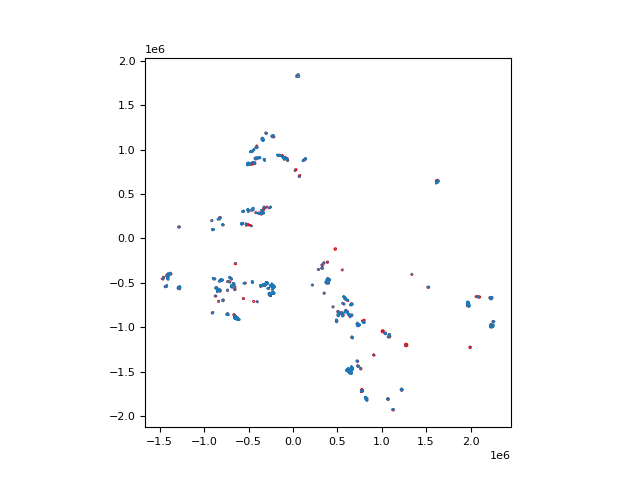

In [58]:
fig, ax = plt.subplots()
static_lakes_gdf.boundary.plot(ax=ax, color='red')
evolving_lakes_gdf.boundary.plot(ax=ax)

# Fig. S1

In [ ]:
ROI_poly = buffered_poly
print(type(buffered_poly))
print(type(ROI_poly))

In [ ]:
ROI_poly = buffered_poly
dataset1 = CS2_dh
dataset2 = ATL15_dh

# Clipping datasets
dataset1_clipped = dataset1.rio.clip(ROI_poly, dataset1.rio.crs)
dataset2_clipped = dataset2.rio.clip(ROI_poly, dataset2.rio.crs)

# Extract min and max of x and y for dataset1
min_x1 = dataset1_clipped.x.min().item()
max_x1 = dataset1_clipped.x.max().item()
min_y1 = dataset1_clipped.y.min().item()
max_y1 = dataset1_clipped.y.max().item()

# Extract min and max of x and y for dataset2
min_x2 = dataset2_clipped.x.min().item()
max_x2 = dataset2_clipped.x.max().item()
min_y2 = dataset2_clipped.y.min().item()
max_y2 = dataset2_clipped.y.max().item()

# Check if the coordinates match
if min_x1 != min_x2 or max_x1 != max_x2 or min_y1 != min_y2 or max_y1 != max_y2:
    raise ValueError("Dataset1 and Dataset2 do not have matching x, y min, max coordinates")

# Establish x_min, x_max, y_min, y_max, 
x_min = min_x1
x_max = max_x1
y_min = min_y1
y_max = max_y1

# Subsetting datasets
# Subset datasets to region of interest for plotting
buffer = 4000
mask_x = (dataset1.x >= x_min-buffer) & (dataset1.x <= x_max+buffer)
mask_y = (dataset1.y >= y_min-buffer) & (dataset1.y <= y_max+buffer)
dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
mask_x = (dataset2.x >= x_min-buffer) & (dataset2.x <= x_max+buffer)
mask_y = (dataset2.y >= y_min-buffer) & (dataset2.y <= y_max+buffer)
dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)
mask_x = (moa_highres_da.x >= x_min-buffer) & (moa_highres_da.x <= x_max+buffer)
mask_y = (moa_highres_da.y >= y_min-buffer) & (moa_highres_da.y <= y_max+buffer)
moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)

In [ ]:
# Modify find contours function to achieve something like less than 5% of contours intersecting with buffer
# gdf = find_evolving_outlines(ROI['name'].values[0], buffered_poly, 0.5, CS2_dh, ATL15_dh)
# gdf = find_evolving_outlines(ROI['name'].values[0], buffered_poly, 0.5, CS2_dh, ATL15_dh)
gdf = find_evolving_outlines('Slessor_2_3_23', buffered_poly, 0.5, CS2_dh, ATL15_dh)

NameError: name 'gdf_subset' is not defined

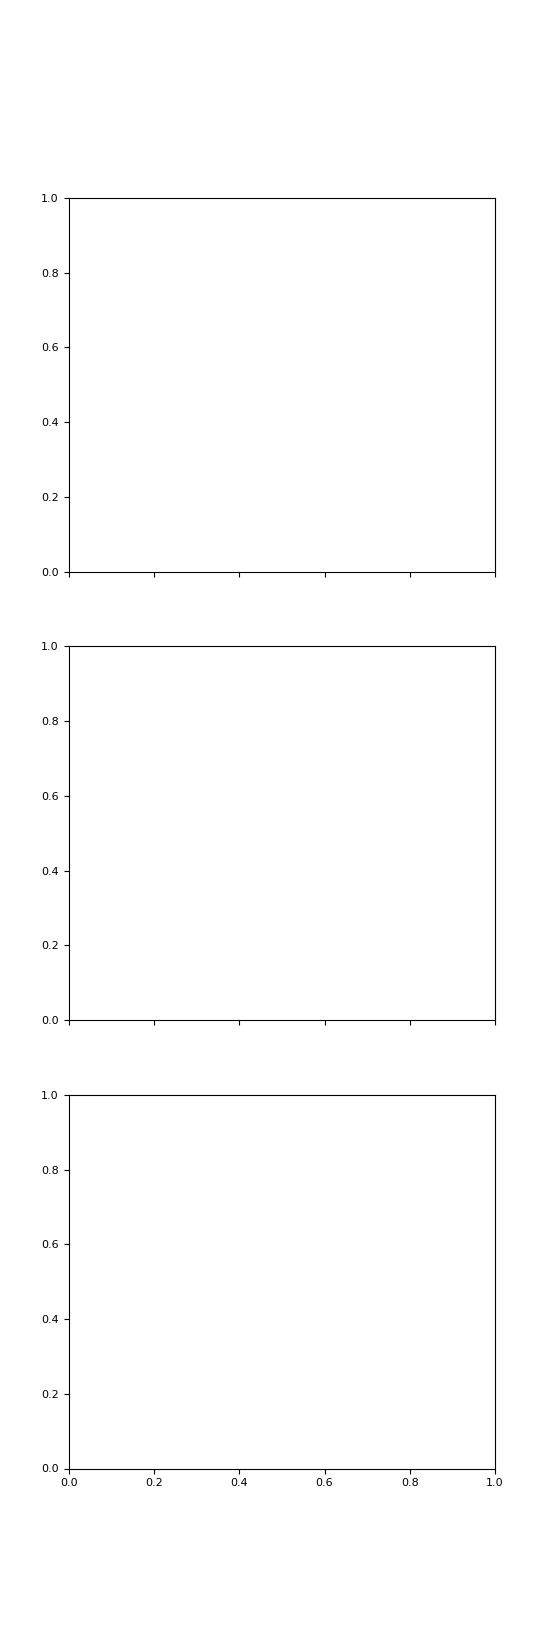

In [51]:
# TODO
# Try other lakes

# Plot Fig. 2
fig, ax = plt.subplots(3,1, sharex=True, figsize=(5.5,16.5))


# Panel A - Plot uplift filling event
# Specify the time value you want to plot
specified_date = datetime.date(2010, 8, 17)
gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] > 0)].boundary.plot(ax=ax[0], color='blue')
gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] < 0)].boundary.plot(ax=ax[0], color='red')

# Calculate the absolute difference between each time in the dataset and the specified time
time_diff = np.abs(midcyc_dates - np.datetime64(specified_date))
# Find the index of the minimum difference
nearest_time_index = time_diff.argmin().item()
if nearest_time_index <= 32:
    dhdt = dataset1_subset.cyc_to_cyc_delta_h[nearest_time_index,:,:]
elif nearest_time_index > 32:
    # Subtract 33 from idx to start over with new dataset
    dhdt = dataset2_subset.cyc_to_cyc_delta_h[(nearest_time_index-33),:,:]

# Plot gridded height change data
divnorm=colors.TwoSlopeNorm(vmin=-1.5, vcenter=0., vmax=1.5)  
img = ax[0].imshow(dhdt, extent=[x_min-buffer, x_max+buffer, y_min-buffer, y_max+buffer], origin='upper', cmap='coolwarm_r', 
                   # norm=colors.CenteredNorm(),
                   norm=divnorm)

# Plot buffered polygon showing extent of evolving outline search
ROI_color = 'magenta'
gpd.GeoSeries(buffered_poly).boundary.plot(ax=ax[0], color=ROI_color)

# Create an axes on the right side of ax1 for the colorbar
cax = fig.add_axes([ax[0].get_position().x1 + 0.15, ax[0].get_position().y0 - 0.092, 0.03, ax[0].get_position().height])
fig.colorbar(img, cax=cax).set_label('height change [m]', size=12)

# Annotate time slice
ax[0].annotate('height change: {} to {}'.format(datetime64_to_fractional_year(cyc_start_dates[nearest_time_index]),
    datetime64_to_fractional_year(cyc_end_dates[nearest_time_index])), 
    xy=(-421e3,1009e3), xycoords='data', fontsize=14)


# Panel B - Plot subsidence draining event
# specified_date = datetime.date(2021, 2, 15)
specified_date = datetime.date(2020, 2, 16)
# specified_date = datetime.date(2015, 8, 17)

gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] > 0)].boundary.plot(ax=ax[1], color='blue')
gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] < 0)].boundary.plot(ax=ax[1], color='red')

# Calculate the absolute difference between each time in the dataset and the specified time
time_diff = np.abs(midcyc_dates - np.datetime64(specified_date))
# Find the index of the minimum difference
nearest_time_index = time_diff.argmin().item()
if nearest_time_index <= 32:
    dhdt = dataset1_subset.delta_h[nearest_time_index+1,:,:]-dataset1_subset.delta_h[nearest_time_index,:,:]
elif nearest_time_index > 32:
    # Subtract 33 from idx to start over with new dataset
    dhdt = dataset2_subset.delta_h[(nearest_time_index-33)+1,:,:]-dataset2_subset.delta_h[(nearest_time_index-33),:,:]

# Plot gridded height change data
img = ax[1].imshow(dhdt, extent=[x_min-buffer, x_max+buffer, y_min-buffer, y_max+buffer], origin='lower', cmap='coolwarm_r', 
                   # norm=colors.CenteredNorm(),
                   norm=divnorm)
gpd.GeoSeries(buffered_poly).boundary.plot(ax=ax[1], color=ROI_color)

ax[1].annotate('height change: {} to {}'.format(datetime64_to_fractional_year(cyc_start_dates[nearest_time_index]),
    datetime64_to_fractional_year(cyc_end_dates[nearest_time_index])), 
    xy=(-421e3,1009e3), xycoords='data', fontsize=14)


# Panel C - Plot outlines in aggregate vs. two past static delineations
# Plot MOA imagery  
ax[2].imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min-buffer, x_max+buffer, y_min-buffer, y_max+buffer])

# Pick colormap and make continuous cmap discrete for evolving outlines
colormap = 'plasma'
continuous_cmap = matplotlib.colormaps[colormap]
discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(midcyc_dates)-1)))

# Norm to time variable
norm = plt.Normalize(mdates.date2num(midcyc_dates[0]), 
                     mdates.date2num(midcyc_dates[-1]))

# Use for loop to store each time slice as line segment to use in legend
# And plot each outline in the geopandas dataframe and color by date
lines = []  # list of lines to be used for the legend
for idx, dt in enumerate(midcyc_dates, 0):
    x = 1; y = 1
    line, = ax[2].plot(x, y, color=discrete_cmap(norm(mdates.date2num(midcyc_dates[idx]))), linewidth=3)
    lines.append(line)
    
    # Filter rows that match the current time slice
    gdf_subset_dt = gdf_subset[gdf_subset['datetime'] == dt]

    # Plotting the subset
    gdf_subset_dt.plot(ax=ax[2], edgecolor=discrete_cmap(norm(mdates.date2num(midcyc_dates[idx]))), facecolor='none')

    
# All panels
# Label axes
ax[2].set_xlabel('x [km]', size=16)
ax[1].set_ylabel('y [km]', size=16)

# ax[0].annotate('A', xy=(-425e3,1049e3), xycoords='data', fontsize=30)
# ax[1].annotate('B', xy=(-425e3,1049e3), xycoords='data', fontsize=30)
# ax[2].annotate('C', xy=(-425e3,1049e3), xycoords='data', fontsize=30)
ax[0].annotate('A', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=30)
ax[1].annotate('B', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=30)
ax[2].annotate('C', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=30)

# Create lines for legend
S09_color = 'lightseagreen'
SF18_color = 'teal'
Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 2)), linewidth=3)
SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 1)), linewidth=3)
ROI = plt.Line2D((0, 1), (0, 0), color=ROI_color, linestyle='solid', linewidth=3)
uplift = plt.Line2D((0, 1), (0, 0), color='blue', linewidth=3)
subsidence = plt.Line2D((0, 1), (0, 0), color='red', linewidth=3)

# Create legends
ax[0].legend([Smith2009, SiegfriedFricker2018, ROI, uplift], 
           ['static outline [10]',
            'static outline [13]', 
            # 'evolving outline ({} m threshold)'.format(threshold)], 
            'evolving outline search limit [this study]',
            'evolving outline - uplift [this study]'], 
             loc='upper right') 

ax[1].legend([subsidence],
           ['evolving outline - subsidence [this study]'], 
             loc='upper right')

legend = ax[2].legend([tuple(lines)], ['evolving outlines [this study]'],
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper center')
legend.get_frame().set_linewidth(0.0)
ax[2].patch.set_alpha(1)

# Create colorbar 
m = plt.cm.ScalarMappable(cmap=discrete_cmap)
m.set_array(np.array([datetime64_to_fractional_year(date) for date in midcyc_dates[0:]]))
cax = inset_axes(ax[2],
                 width="100%",
                 height="2.5%",
                 loc=3,
                 bbox_to_anchor=[0,-0.14,1,1],
                 bbox_transform=ax[2].transAxes,
                 borderpad=0,
                 )
cbar=fig.colorbar(m, ticks=np.array([2010,2012,2014,2016,2018,2020,2022]), 
             cax=cax, orientation='horizontal').set_label('evolving outline year', size=15)

# Plot inset map
axIns = ax[0].inset_axes([0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
axIns.set_aspect('equal')
moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
axIns.axis('off')
# # Plot black rectangle to indicate location
# rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
# axIns.add_artist(rect)
# Plot red star to indicate location
axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
    linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

# # Add annotation to the opposite side of the colorbar
# cbar.ax.text(1.1, 0.5, 'CryoSat-2 era', va='center', ha='left', transform=cbar.ax.transAxes)

for i in ax: 
    S09_outlines.boundary.plot(ax=i, edgecolor=S09_color, facecolor='none', linestyle=(0, (1, 2)), linewidth=3, alpha=1, zorder=0)
    SF18_outlines.boundary.plot(ax=i, edgecolor=SF18_color, facecolor='none', linestyle=(0, (1, 1)), linewidth=3, alpha=1, zorder=0)
    
    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    i.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    i.yaxis.set_major_formatter(ticks_y)
    
    # i.set(xlim=(x_min-buffer, x_max+buffer), ylim=(y_min-buffer, y_max+buffer))   
    i.set(xlim=(x_min-buffer, x_max+buffer), ylim=(y_min-buffer, y_max+buffer))   

plt.tight_layout()

plt.show()

In [52]:
# I can't figure out why data_counts plot looks sparse when you plot at continental scale
plt.close()
for idx in range(145, len(static_lakes_gdf)):

    # Define lake name and polygon
    lake_name = lake_gdf.name.values[0]
    lake_poly = lake_gdf.iloc[0].geometry

    # # Create buffered polygons for various multiples of lake area to find which
    # # best emcompasses the height change signals at previously identified lakes
    buffered_poly_2x = muliple_area_buffer(lake_poly, 2)
    # buffered_poly_3x = muliple_area_buffer(lake_poly, 3)
    # buffered_poly_4x = muliple_area_buffer(lake_poly, 4)
    # buffered_poly_5x = muliple_area_buffer(lake_poly, 5)

    # Establish x_min, x_max, y_min, y_max
    x_min, y_min, x_max, y_max = buffered_poly_2x.iloc[0].geometry.bounds
    x_buffer = abs(x_max-x_min)*10
    y_buffer = abs(y_max-y_min)*10

    # Subsetting datasets
    mask_x = (dataset1.x >= x_min - x_buffer) & (dataset1.x <= x_max + x_buffer)
    mask_y = (dataset1.y >= y_min - y_buffer) & (dataset1.y <= y_max + y_buffer)
    dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
    mask_x = (dataset2.x >= x_min - x_buffer) & (dataset2.x <= x_max + x_buffer)
    mask_y = (dataset2.y >= y_min - y_buffer) & (dataset2.y <= y_max + y_buffer)
    dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)

    # Make output folders
    create_folder(OUTPUT_DIR + '/{}'.format('plot_data_counts'))
    create_folder(OUTPUT_DIR + '/plot_data_counts/{}'.format(lake_name))
    print('Now creating/saving plots...')

    # Create lines for legend
    S09_color = 'cyan'
    SF18_color  = 'darkcyan'
    static_lakes_gdf_postSF18_color = 'deepskyblue'
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
    static_lakes_gdf_postSF18 = plt.Line2D((0, 1), (0, 0), color=static_lakes_gdf_postSF18_color, linestyle=(0, (1, 1)), linewidth=2)

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(33,34):#len(midcyc_dates)):
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            count_subset = dataset1_subset['data_count'][idx,:,:]
            count_subset.rio.write_crs("epsg:3031", inplace=True)

        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            count_subset = dataset2_subset['data_count'][(idx-33),:,:]
            count_subset.rio.write_crs("epsg:3031", inplace=True)

        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        # if np.any(~np.isnan(count_subset)):
        # Create fig, ax
        fig, ax = plt.subplots()

        # Plot figure
        img = ax.imshow(count_subset, extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer], 
            origin='lower', cmap='viridis')

        buffered_poly_2x.boundary.plot(ax=ax, edgecolor='r', facecolor='none', linewidth=5)

NameError: name 'lake_gdf' is not defined

NameError: name 'buffered_poly_2x' is not defined

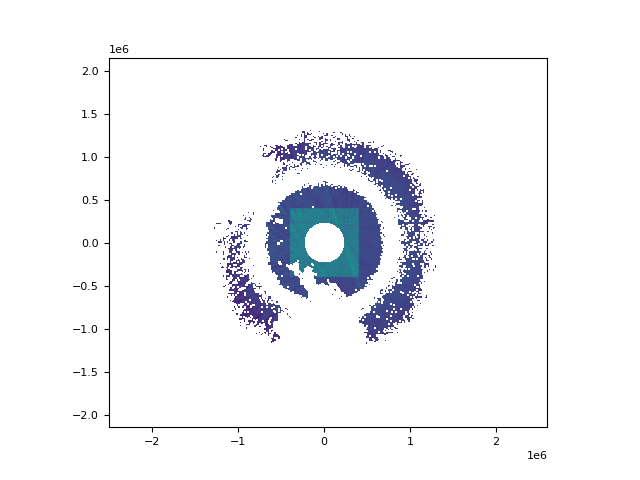

In [53]:
# Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
# Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
# if np.any(~np.isnan(count_subset)):
plt.close()
# Create fig, ax
fig, ax = plt.subplots()

idx=44

# Plot figure
img = ax.imshow(dataset2['data_count'][(idx-33),:,:], 
    # extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer],
    extent=[dataset2.x.min(), dataset2.x.max(), dataset2.y.min(), dataset2.y.max()], 
    origin='lower', 
    # cmap='viridis'
    )

buffered_poly_2x.boundary.plot(ax=ax, edgecolor='r', facecolor='none', linewidth=5)
plt.show()
Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=0.5)

# Add colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('data counts', size=15)

plt.show()